In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
!pip install lxml
import lxml
import numpy as np
import pandas as pd
!pip install shapely

#from shapely.geometry import Polygon, Point, MultiPolygon

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('ggplot') # optional: for ggplot-like style
!pip install folium
import folium
# import k-means and evaluation for clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist 

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

  Using cached https://files.pythonhosted.org/packages/a2/fb/7a7af9ef7a35d16fa23b127abee272cfc483ca89029b73e92e93cdf36e6b/Shapely-1.6.4.post2.tar.gz


    ERROR: Command errored out with exit status 1:
     command: 'C:\ProgramData\Anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Eric\\AppData\\Local\\Temp\\pip-install-drpqotvk\\shapely\\setup.py'"'"'; __file__='"'"'C:\\Users\\Eric\\AppData\\Local\\Temp\\pip-install-drpqotvk\\shapely\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base pip-egg-info
         cwd: C:\Users\Eric\AppData\Local\Temp\pip-install-drpqotvk\shapely\
    Complete output (9 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\Eric\AppData\Local\Temp\pip-install-drpqotvk\shapely\setup.py", line 80, in <module>
        from shapely._buildcfg import geos_version_string, geos_version, \
      File "C:\Users\Eric\AppData\Local\Temp\pip-install-drpqotvk\shapely\shapely\_buildcfg.

# New Orleans Incidents and Venues

## Table of contents
1. [Introduction](#Introduction)
2. [Data](#Data)
3. [Methodology](#Methodology)
4. [Results](#Results)
5. [Discussion](#Discussion)
6. [Conclusion](#Conclusion)

<a name="Introduction"></a>

## 1. Introduction
---
New Orleans is a beautiful and complicated city in southern Louisiana with a 300 year history. It's known for jazz, Creole/Cajun cuisine, and Mardi Gras. The city has generally been the most populous of the state, but suffered a large outflux after the 2005 disaster, Hurricane Katrina. For 2019, it's estimated to be home to **423,656 people** in **13 districts** with **72 distinct neighborhoods**, coming out with a population density around 858 persons per square kilometer. However, along with its rich culture, the city has been riddled with crime, poverty, and flooding. The New Orleans Police Department is estimated to be understaffed by 30- 50% depending on the unit [(see this article)](https://www.fox8live.com/story/35820316/new-orleans-police-pay-increase-is-attempt-to-stop-terrible-attrition-rate/ "Police Troubles")
 and as such must stretch their resources by whatever means they have. In stretching those resources, they must be informed on high problem times, areas, and what to expect. This project focuses upon the relation between New Orleans locales and 911 (emergency/crime) incident calls, seeking to find patterns to better distribute local police patrols and response units. It leverages data on venues, neighborhood zones, and 911 calls in exploring these patterns. Lastly, traffic and miscellaneous incidents will be *excluded* from the project. 
 
Specifically, we want to answer the **question**:
 * Can we use machine learning to cluster New Orleans areas based on 911 incidents and venue types present?

We will also *explore*:
 * Incident totals by neighborhood, incident type, and month of occurrence 
 * Venue types by neighborhood
  
Which may help the following **stakeholders**:
* Local police and emergency responders
* Government officials allocating city resources, business licenses (if certain venue types trend with crime), or police funding/staffing

Additionally, if the information from this project is combined with housing data, it could be useful for:
* Realestate investors and developers 
* Non-locals looking to move to the area

Considering the problem and stakeholders, we can create a map of New Orleans where each neighborhood is clustered according to frequency of 911 incidents and venue types. This may inform where and what type of emergency resource is most needed and around which venue type(s) the incidents occur. 

<a name="Data"></a>

## 2. Data
---
### 2.1 Data Sources
---
Data for this project comes from four main sources:

1. [**Calls for Service 2018**](https://data.nola.gov/api/views/9san-ivhk/rows.csv?accessType=DOWNLOAD "Calls for Service 2018 csv")   
This is a log of all 911 calls in New Orleans in 2018. It contains 175 different types of incidents ranging from traffic violations to homicide. Each incident’s time, location, priority, and a range of other factors are listed. For this project, incidents related to neighborhood safety and crime will be used. Those such as traffic, medical, and miscellaneous will be *excluded*.
2. [**Foursquare API**](https://developer.foursquare.com/docs/api/endpoints "Foursquare endpoints")    
Venues and their types can be retrieved based on geolocations from a given neighborhood’s centroid (listed on Wikipedia). 
3. [**Wikipedia list of Neighborhoods**](https://en.wikipedia.org/wiki/Neighborhoods_in_New_Orleans "NOLA Neighborhoods")   
A table of New Orleans neighborhoods and their centroid coordinates can be scraped from wikipedia using pandas. 
4. [**Neighborhood boundaries**](https://data.nola.gov/api/views/abhb-x4ch/rows.csv?accessType=DOWNLOAD "Neighborhood Boundaries")    
This is a list of New Orleans neighborhoods and their geographic boundaries as defined by the US census. Incidents from the calls of service will be categorized into neighborhoods based on geolocation using this data.

### 2.2 Data Cleaning and Selection
---
Data from Calls for Service 2018 is a huge table consisting of over 460,000 entries. Many fields contain missing values or irrelevant content for this study. In cleaning the table, several things must be done. First, essential columns must be identified and erroneous ones dropped. Second, rows with an incident type not pertaining to neighborhood safety or crime are to be removed. Third, missing values need to be dropped or filled. Finally, naming schemes of rows are revised. 

Scanning the columns in the Calls for Service data set, we can see an incident’s police log number, type, the police code for the type, its initial type and code, 3 different time stamps for time created, arrived, and closed; the disposition (what happened when the responders arrived), and several other fields. For this study, the type and location fields are essential. We will also keep the block address, zip, beat, and police district for additional location information. One time stamp (TimeCreate) and the type code (Type_) are retained for reference and later analysis.       

Summary of Columns | Column Names | Total  
--- | --- | ---  
**Columns kept** | Type_, TypeText, TimeCreate, Beat, BLOCK_ADDRESS, Zip, PoliceDistrict, Location | 8  
**Columns discarded** | NOPD_Item, Priority, InitialType, InitialTypeText, InitialPriority, MapX, MapY, TimeDispatch, TimeArrive, TimeClosed, Disposition, DispositionText, SelfInitiated	| 13  

The next big item for this data set is retaining rows with a relevant type field. As stated before, we want rows that are related to neighborhood safety and crime. Some examples of types to be discarded are traffic related incidents, MEDICAL, and AREA CHECK. For a full list, check below:  

Type Removed | Note  
--- | ---  
'ABANDONED BOAT' | --    
'ABANDONED VEHICLE' | --  
'AIRPLANE CRASH' | --  
'AREA CHECK' | --  
'ATTACHMENT' | --  
'AUTO ACCIDENT' | --  
'AUTO ACCIDENT CITY VEHICLE' | --  
'AUTO ACCIDENT FATALITY' | --  
'AUTO ACCIDENT POLICE VEHICLE' | --  
'AUTO ACCIDENT WITH INJURY' | --  
'BUSINESS CHECK' | --  
'CAD TEST' | --  
'COMPLAINT OTHER' | --  
'DIRECTED PATROL' | --  
'DIRECTED TRAFFIC ENFORCEMENT' | --  
'DISTURBANCE (OTHER)' | May be safety related, but not enough info is available    
'ELECTRONIC MONITORING' | --  
'FLOOD EVENT' | --  
'FLOODED VEHICLE' | --  
'INCIDENT REQUESTED BY ANOTHER AGENCY' | --  
'LOST PROPERTY' | --  
'MEDICAL' | --  
'MEDICAL - NALOXONE' | --  
'MEET AN OFFICER' | --  
'MUNICIPAL ATTACHMENT' | --  
'OFFICER NEEDS ASSISTANCE' | --  
'PARADE ITEM NUMBER' | --  
'RECOVERY OF VEHICLE' | --  
'RESIDENCE CHECK' | --  
'RETURN FOR ADDITIONAL INFO' | --  
'SILENT 911 CALL' | --  
'TAKING TEMPORARY POSSESSION' | --  
'TOW IMPOUNDED VEHICLE (PRIVATE)' | --  
'TRAFFIC ATTACHMENT' | --  
'TRAFFIC CONGESTION' | --  
'TRAFFIC INCIDENT' | --  
'TROOP N AREA - BUSINESS - RESIDENCE CHECK' | --  
'UNDERPASS MONITORING OR CLOSURE' | --  
'WALKING BEAT' | --  
'WARR STOP WITH RELEASE' | --  
**TOTAL REMOVED** | **40**  
**TOTAL RETAINED** | **135**  

It could be argued that other types not removed should be or some removed should be retained. However, without consulting experts the above items are what we will discard. 



After filtering the necessary columns and rows, we drop all rows with nan values in the Location field. Rows marked with (0, 0) are also dropped. Lastly, columns are renamed as follows:  

Initial Name | Final Name   
--- | ---  
Type_ | Code  
TypeText | Type  
TimeCreate | Time  
Beat | Beat  
BLOCK_ADDRESS | Address  
Zip | Zip  
PoliceDistrict | District  
Location | Coordinates    

Data from both Foursquare and Wikipedia is cleaned and formatted as it is retrieved. Foursquare venues are drawn from within a 750 m radius from each neighborhoods centroid. Their type and location will also be retrieved.  As for neighborhood boundaries, the boundary information is stored as a MULTIPOLYGON type from a different kernel. We will change this into a POLYGON type from the shapely library in python. Later, we can pass the coordinates from Calls for Service as "points" to see if they are contained in the POLYGON, thus assigning their neighborhood. The necessary columns from this data set are "the_geom" and "Neighborhood". "the_geom" is renamed as "Poly". Last, the neighborhood listings in the Wikipedia list and Neighborhood boundaries are reconciled--the only difference being an additional space in "St. Anthony" in the Neighborhood Boundaries data set.  

### 2.3 Data Examples
---
- **1. Calls for Service 2018** (before cleaning)

In [3]:
# The code was removed by Watson Studio for sharing.

NOPD_Item Type_             TypeText Priority InitialType  \
0  B0918118  103M       MENTAL PATIENT       2C          67   
1  A1964518   67C  THEFT FROM EXTERIOR       1A         62C   
2  B0853118    21      COMPLAINT OTHER       1J         103   
3  B0901318   103  DISTURBANCE (OTHER)       1C         103   
4  B0894018   107    SUSPICIOUS PERSON       2C         107   

           InitialTypeText InitialPriority      MapX     MapY  \
0                    THEFT              1G  37369000  3513814   
1  SIMPLE BURGLARY VEHICLE              1G         0        0   
2      DISTURBANCE (OTHER)              1C   3696210   550646   
3      DISTURBANCE (OTHER)              1C   3674468   523681   
4        SUSPICIOUS PERSON              2C   3662712   530883   

               TimeCreate  ...              TimeArrive  \
0  02/08/2018 08:35:29 PM  ...  02/08/2018 08:37:45 PM   
1  01/17/2018 04:10:29 PM  ...  01/18/2018 02:34:08 AM   
2  02/08/2018 10:29:36 AM  ...  02/08/2018 06:21:40 PM   
3  02/08/2018 05:44:10 PM  ...  02/08/2018 06:09:17 PM   
4  02/08/2018 04:55:15 PM  ...  02/08/2018 05:02:55 PM   

               TimeClosed Disposition         DispositionText SelfInitiated  \
0  02/08/2018 09:57:14 PM         NAT  Necessary Action Taken             N   
1  01/18/2018 03:14:11 AM         GOA         GONE ON ARRIVAL             N   
2  02/08/2018 06:28:41 PM         NAT  Necessary Action Taken             N   
3  02/08/2018 06:52:40 PM         NAT  Necessary Action Taken             N   
4  02/08/2018 05:09:17 PM         GOA         GONE ON ARRIVAL             N   

   Beat           BLOCK_ADDRESS      Zip  PoliceDistrict  \
0  2S02   087XX S Claiborne Ave  70118.0               2   
1  7L03  147XX Chef Menteur Hwy      NaN               0   
2  7A01        037XX Downman Rd  70126.0               3   
3  6F02     029XX S Saratoga St  70115.0               6   
4  2K03      018XX Cambronne St  70118.0               2   

                      Location  
0                   (0.0, 0.0)  
1                          NaN  
2  (30.00763148, -90.02092967)  
3  (29.93415313, -90.09054327)  
4   (29.9543012, -90.12741579)  

[5 rows x 21 columns]

**After cleaning**

In [4]:

#drop unnecessary columns
callsdf.drop(columns=['NOPD_Item', 'Priority', 'InitialType', 'InitialTypeText', 'InitialPriority', 'MapX', 'MapY', 'TimeDispatch', 'TimeArrive', 'TimeClosed', 'Disposition', 'DispositionText', 'SelfInitiated'], inplace=True) #drop unnecessary columns

#drop unnecessary types
types = callsdf['TypeText'].unique().tolist()
types = sorted(types)
removes =[]
rs = [0, 1, 18, 19, 24, 25, 26, 27, 28, 29, 38, 39, 42, 51, 52, 55, 60, 67, 68, 88, 92, 93, 94, 96, 101, 105, 109, 119, 121, 122, 128, 153, 159, 160, 161, 162, 163, 169, 173, 174]   # non-crime incidents     

for i in rs:
    removes.append(types[i]) #make traffic, medical, and misc incidents

removes #list of traffic, medical, and misc incidents
civildf = callsdf[~callsdf.TypeText.isin(removes)] #get df without traffic, medical, and miscillaneous incidents

#drop rows with nan and 0, 0 values in Location
civildf.Location.replace(to_replace='(0.0, 0.0)', value=np.nan, inplace=True)
civildf.dropna(subset=['Location'], inplace=True)

#Reset the index
civildf.reset_index(inplace=True)
civildf.drop(columns='index', inplace=True)

#Change our location values from string type into a latitude, longitude tuple 
civildf['Location'] = civildf['Location'].str.replace('[()]', '', regex=True)
for i in range(civildf.shape[0]):
    b = civildf.loc[i, 'Location'].split(",") #split into a list
    for j in range(len(b)):
        b[j] = float(b[j])
    civildf.at[i, 'Location'] = b #reassign poly value into list of x, y tuples
    
#rename columns
civildf.columns=['Code', 'Type', 'Time', 'Beat', 'Address', 'Zip', 'District', 'Coordinates']
civildf.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__ma

Code               Type                    Time  Beat  \
0  107  SUSPICIOUS PERSON  02/08/2018 04:55:15 PM  2K03   
1  107  SUSPICIOUS PERSON  02/08/2018 05:20:45 PM  5I04   
2  62B  BUSINESS BURGLARY  02/08/2018 05:19:41 AM  7L01   
3   29              DEATH  02/08/2018 10:16:26 AM  6P01   
4   67              THEFT  02/08/2018 10:54:10 AM  5L01   

                      Address      Zip  District                  Coordinates  
0          018XX Cambronne St  70118.0         2   [29.9543012, -90.12741579]  
1  Andry St & N Claiborne Ave  70117.0         5    [29.9668437, -90.0168289]  
2          046XX Michoud Blvd  70129.0         7  [30.03203358, -89.92870826]  
3     014XX General Taylor St  70115.0         6  [29.92592877, -90.09646117]  
4            023XX N Tonti St  70117.0         5  [29.98070722, -90.05459674]

- **2. Foursquare API**  
Venues and their type within 750 m from each neighborhood's centroid will be combined with the Wikipedia list of Neighborhoods later.

* **3. Wikipedia List of Neighborhoods**

In [3]:
tables = pd.read_html('https://en.wikipedia.org/wiki/Neighborhoods_in_New_Orleans', header=0)
neighborhoods = tables[0]
neighborhoods.head()

Neighborhood  Longitude   Latitude
0  U.S. NAVAL BASE -90.026093  29.946085
1    ALGIERS POINT -90.051606  29.952462
2          WHITNEY -90.042357  29.947200
3          AUDUBON -90.121450  29.932994
4       OLD AURORA -90.000000  29.924440

In [41]:
#for those with lxml problem
neighborhoods = pd.read_csv('neighborhoods.csv')
neighborhoods.head()

Neighborhood  Longitude   Latitude
0  U.S. NAVAL BASE -90.026093  29.946085
1    ALGIERS POINT -90.051606  29.952462
2          WHITNEY -90.042357  29.947200
3          AUDUBON -90.121450  29.932994
4       OLD AURORA -90.000000  29.924440

* **4. Neighborhood Boundaries** (before cleaning)

In [7]:
# The code was removed by Watson Studio for sharing.

the_geom  OBJECTID  \
0  MULTIPOLYGON (((-90.057938033305 29.9380212048...       906   
1  MULTIPOLYGON (((-90.100964619377 29.9171524047...       883   
2  MULTIPOLYGON (((-90.029798602096 29.9825104216...       889   
3  MULTIPOLYGON (((-90.112151624385 29.9773204178...       881   
4  MULTIPOLYGON (((-90.090187615105 29.9286374080...       912   

            Neighborhood  Shape_Length    Shape_Area  
0  LOWER GARDEN DISTRICT  30616.527778  3.039541e+07  
1         EAST RIVERSIDE  12713.023743  6.908365e+06  
2            FLORIDA DEV   5959.031328  1.540363e+06  
3                  DIXON  13225.197641  7.050618e+06  
4                  MILAN  16762.463146  1.470241e+07

**After cleaning**

In [8]:
boundariesdf.columns=['Poly', 'id', 'Neighborhood', 'length', 'area'] #Change column names
boundariesdf.drop(columns=['id', 'length', 'area'], inplace=True)
df1 = boundariesdf
df1['Poly'] = df1['Poly'].str.replace('[MULTIPOLYGON((()))]', '', regex=True) #remove the multiploy and stuff
for hood in range(72):
    x = df1.loc[hood, 'Poly'].split(",") #split into a list
    for i in range(0, len(x)):
        x[i] = x[i].split() #split list items into tuples
        for j in range(len(x[i])):
            x[i][j] = float(x[i][j]) #convert tuple items into floats
    df1.at[hood, 'Poly'] = x #reassign poly value into list of x, y tuples
df1['Poly'] = df1['Poly'].apply(Polygon) # convert our list into polygon objects
boundariesdf.replace(to_replace='ST.  ANTHONY', value='ST. ANTHONY', inplace=True)
boundariesdf.head()

Poly           Neighborhood
0  POLYGON ((-90.05793803330501 29.93802120487, -...  LOWER GARDEN DISTRICT
1  POLYGON ((-90.100964619377 29.917152404751, -9...         EAST RIVERSIDE
2  POLYGON ((-90.02979860209599 29.982510421634, ...            FLORIDA DEV
3  POLYGON ((-90.11215162438501 29.977320417804, ...                  DIXON
4  POLYGON ((-90.09018761510499 29.928637408086, ...                  MILAN

<a name="Methodology"></a>
## 3. Methodology
---  

As previously mentioned, the focus of this project is to explore relationships between venues and 911 incident occurrence in New Orleans neighborhoods, with the ultimate goal of providing useful information for government resource allocation. Towards that end, an exploratory analysis will be conducted using *descriptive statistics* to show:  

1. Top Incident Types (what incidents occur most often and the neighborhoods where they most occur)
2. Frequency Distribution of Incidents (in what quantity do incident types usually occur)
3. Top Neighborhoods of Incident Occurrence (where incidents occur most often and what the types of incidents occur in these neighborhoods)
4. Frequency Distribution of Total Incident Occurrence by Neighborhood (how many incidents usually occur in neighborhoods)
5. Choropleth map of incident occurrence in New Orleans by neighborhood 
6. Time Series of Incidents by Month
7. Top Venue Types and Frequencies

K-means machine learning will be used 3 separate times to cluster neighborhoods based on incident type frequency, venue type frequency, and then incident type frequency and venue type frequency together. K-means was chosen based on its efficiency and speed for working with a large data set. The elbow method is used to choose the best k for each clustering, checking both distortion and inertia. Neighborhoods will be displayed upon a folium map with their K-means cluster labels.  

Finally, based on k-means cluster labels for incident type and venue type frequencies, connections will be examined and discussed. 

### 3.1 Exploratory Analysis
---
In order to complete our exploratory analysis as mentioned in the methodology, we'll need to add neighborhood labels to the incidents data in `civildf`. We'll drop any rows that do not receive an appropriate neighborhood label. Afterward, we can explore incidents by neighborhood and top incidents overall. We will also convert our `Time` column information to a timestamp for exploring monthly incident occurrence by neighborhood and type. Please note that the following code for adding neighborhood labels has a very long runtime. A completed csv is available in the github project folder.

In [10]:
#add in a neighborhood column
civildf['Neighborhood']=civildf['Coordinates']


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [ ]:
#add neighborhood field to each data point in 
for c in range(0, civildf.shape[0]):
    p = Point(civildf.loc[c, 'Coordinates'][1], civildf.loc[c, 'Coordinates'][0])
    for h in range(boundariesdf.shape[0]):
        if boundariesdf.loc[h, 'Poly'].contains(p):
            civildf.loc[c, 'Neighborhood']=boundariesdf.loc[h, 'Neighborhood']
            break
        else:
            continue

project.save_data(file_name = "civildf.csv",data = civildf.to_csv(index=False), overwrite=True) #saves the file on IBM Watson Studio

In [8]:
# The code was removed by Watson Studio for sharing.

Code               Type                    Time  Beat  \
0  107  SUSPICIOUS PERSON  02/08/2018 04:55:15 PM  2K03   
1  107  SUSPICIOUS PERSON  02/08/2018 05:20:45 PM  5I04   
2  62B  BUSINESS BURGLARY  02/08/2018 05:19:41 AM  7L01   
3   29              DEATH  02/08/2018 10:16:26 AM  6P01   
4   67              THEFT  02/08/2018 10:54:10 AM  5L01   

                      Address      Zip  District                  Coordinates  \
0          018XX Cambronne St  70118.0         2   [29.9543012, -90.12741579]   
1  Andry St & N Claiborne Ave  70117.0         5    [29.9668437, -90.0168289]   
2          046XX Michoud Blvd  70129.0         7  [30.03203358, -89.92870826]   
3     014XX General Taylor St  70115.0         6  [29.92592877, -90.09646117]   
4            023XX N Tonti St  70117.0         5  [29.98070722, -90.05459674]   

       Neighborhood  
0          LEONIDAS  
1  LOWER NINTH WARD  
2   VILLAGE DE LEST  
3             TOURO  
4          ST. ROCH

In [9]:
#rows that didn't receive a proper neighborhood label
civildf[~civildf['Neighborhood'].isin(boundariesdf['Neighborhood'])].shape

(38, 9)

In [11]:
#drop rows that didn't receive a proper neighborhood label
civildf=civildf[civildf['Neighborhood'].isin(boundariesdf['Neighborhood'])]
civildf.reset_index(inplace=True)
civildf.drop(columns='index', inplace=True)
civildf.head()

Code               Type                    Time  Beat  \
0  107  SUSPICIOUS PERSON  02/08/2018 04:55:15 PM  2K03   
1  107  SUSPICIOUS PERSON  02/08/2018 05:20:45 PM  5I04   
2  62B  BUSINESS BURGLARY  02/08/2018 05:19:41 AM  7L01   
3   29              DEATH  02/08/2018 10:16:26 AM  6P01   
4   67              THEFT  02/08/2018 10:54:10 AM  5L01   

                      Address      Zip  District                  Coordinates  \
0          018XX Cambronne St  70118.0         2   [29.9543012, -90.12741579]   
1  Andry St & N Claiborne Ave  70117.0         5    [29.9668437, -90.0168289]   
2          046XX Michoud Blvd  70129.0         7  [30.03203358, -89.92870826]   
3     014XX General Taylor St  70115.0         6  [29.92592877, -90.09646117]   
4            023XX N Tonti St  70117.0         5  [29.98070722, -90.05459674]   

       Neighborhood  
0          LEONIDAS  
1  LOWER NINTH WARD  
2   VILLAGE DE LEST  
3             TOURO  
4          ST. ROCH

In [4]:
#load saved data frame 
civildf = pd.read_csv('civildffinal.csv')
civildf.head()

Code               Type                 Time  Beat  \
0  107  SUSPICIOUS PERSON  2018-02-08 16:55:15  2K03   
1  107  SUSPICIOUS PERSON  2018-02-08 17:20:45  5I04   
2  62B  BUSINESS BURGLARY  2018-02-08 05:19:41  7L01   
3   29              DEATH  2018-02-08 10:16:26  6P01   
4   67              THEFT  2018-02-08 10:54:10  5L01   

                      Address      Zip  District                  Coordinates  \
0          018XX Cambronne St  70118.0         2   [29.9543012, -90.12741579]   
1  Andry St & N Claiborne Ave  70117.0         5    [29.9668437, -90.0168289]   
2          046XX Michoud Blvd  70129.0         7  [30.03203358, -89.92870826]   
3     014XX General Taylor St  70115.0         6  [29.92592877, -90.09646117]   
4            023XX N Tonti St  70117.0         5  [29.98070722, -90.05459674]   

       Neighborhood  
0          LEONIDAS  
1  LOWER NINTH WARD  
2   VILLAGE DE LEST  
3             TOURO  
4          ST. ROCH

In [5]:
#convert the time information to a pandas timestamp
civildf['Time'] = pd.to_datetime(civildf['Time'])

In [120]:
# The code was removed by Watson Studio for sharing.

{'file_name': 'civildffinal.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmdatasciencecapstone-donotdelete-pr-cy4geiea48169q',
 'asset_id': 'f02270f7-871b-4590-9590-66a0e100f9f4'}

<a name="3.1.1"></a>
#### 3.1.1 Top Incident Types
---
To get our top incident types, we can group the incidents from `civildf` by type and get the type count. Following that, we can represent this data in a bar chart showing the top 20 incident types. Afterwards, we can explore where each of these incident types occur most. 

In [6]:
#Dataframe of total incidents per incident type
typetotals = civildf.Type.value_counts().to_frame()
typetotals.columns=['Count']
typetotals.head()

Count
BURGLAR ALARM, SILENT  23342
SUSPICIOUS PERSON      15028
DOMESTIC DISTURBANCE   12109
HIT & RUN               8341
THEFT                   5952

<function matplotlib.pyplot.show(*args, **kw)>

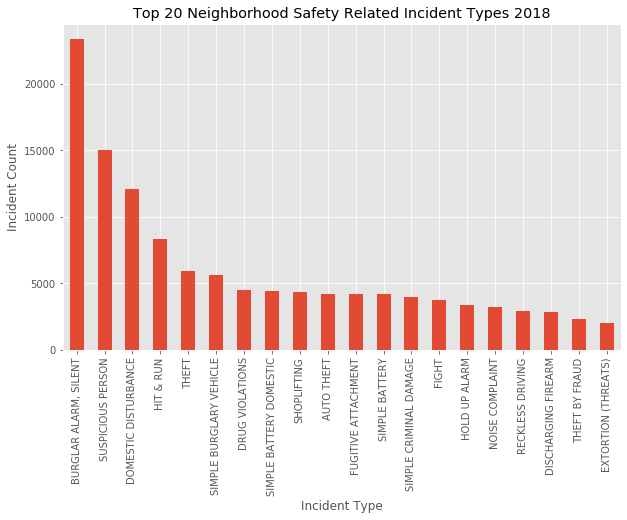

In [7]:
#barchart of top 20 Incident Types
typetotals.head(20).plot(kind='bar', figsize=(10, 6), legend=None)
plt.ylabel('Incident Count')
plt.xlabel('Incident Type')
plt.title('Top 20 Neighborhood Safety Related Incident Types 2018')
plt.show

<a name="3.1.1b"></a>
Great! Let's check the top neighborhoods for each of these incident types and the descriptive statistics per type (statistics are inclusive of all neighborhoods where the incident type occurred).

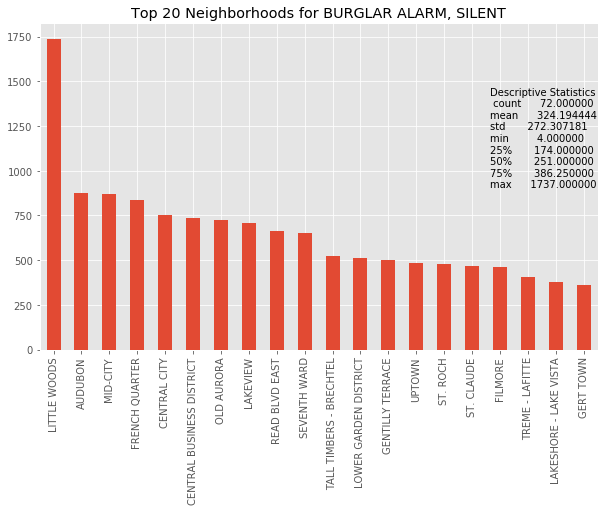

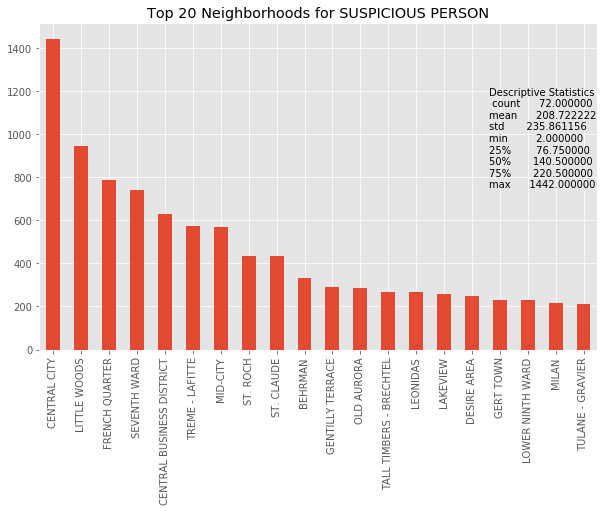

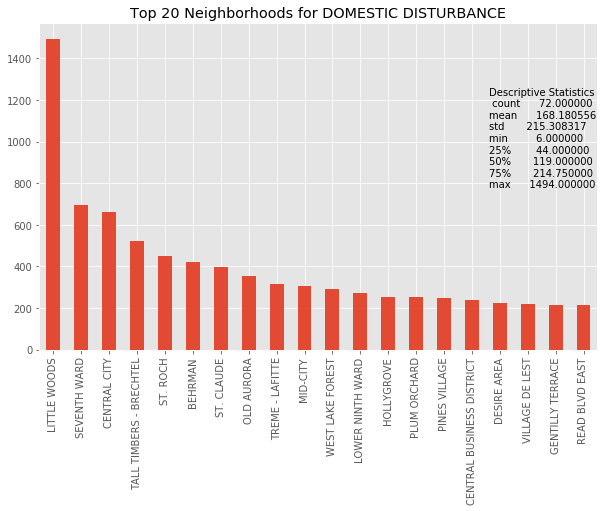

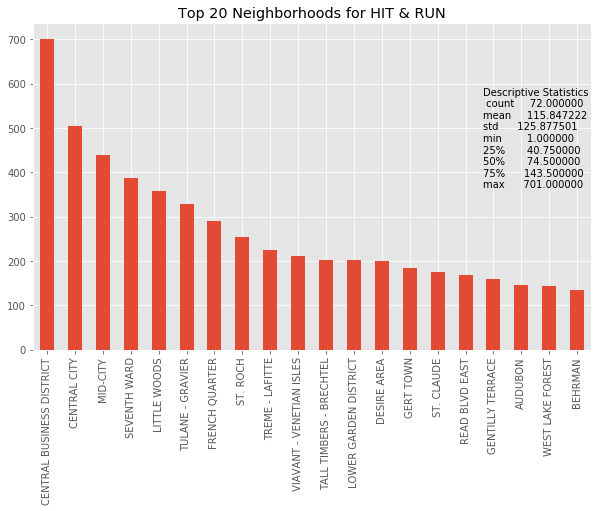

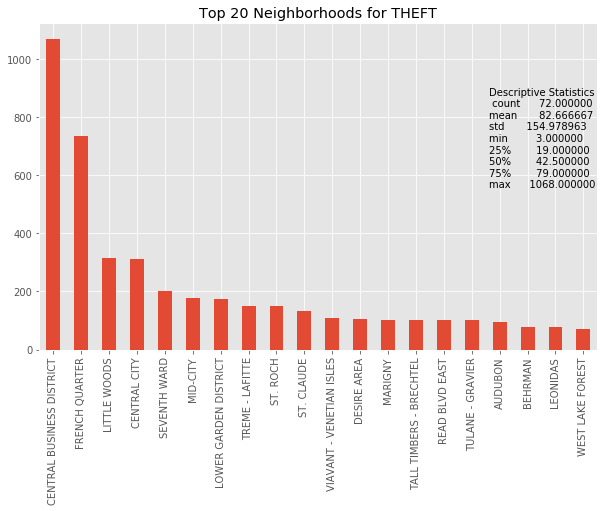

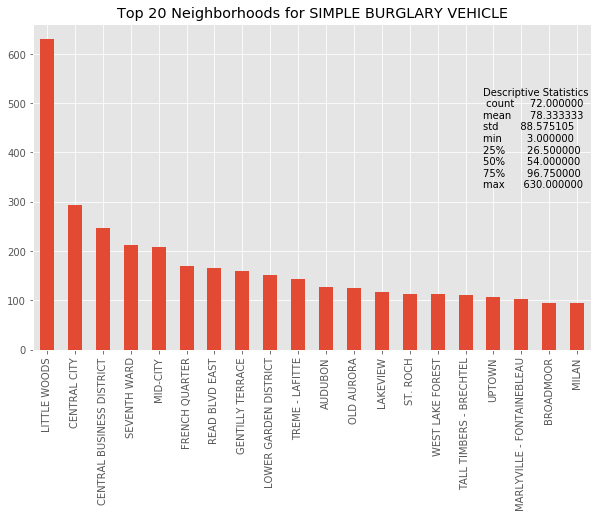

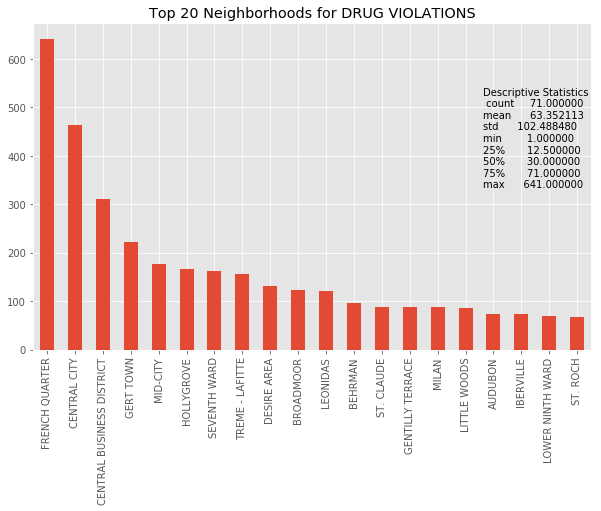

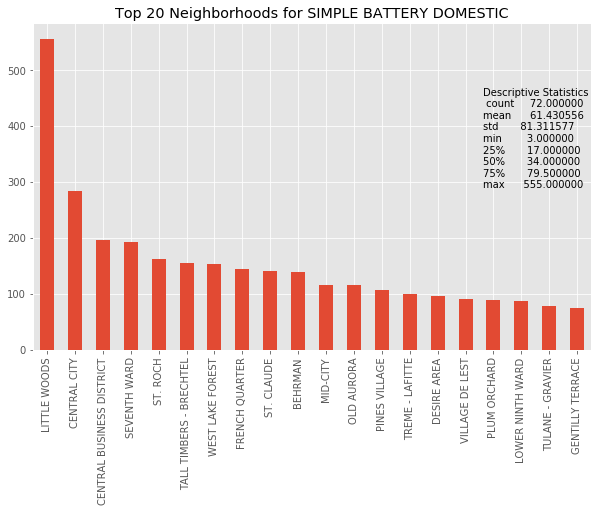

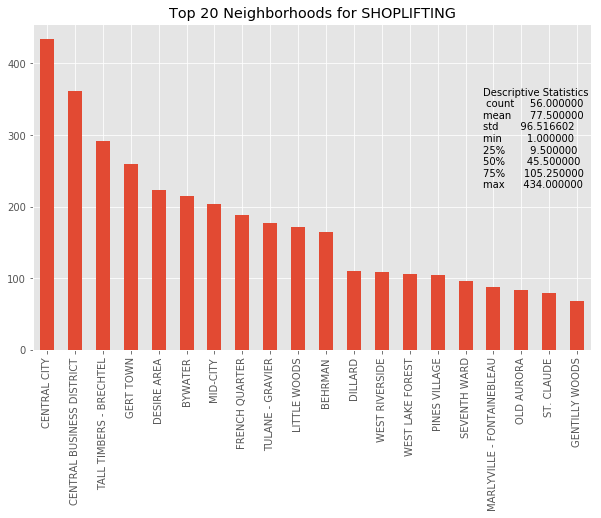

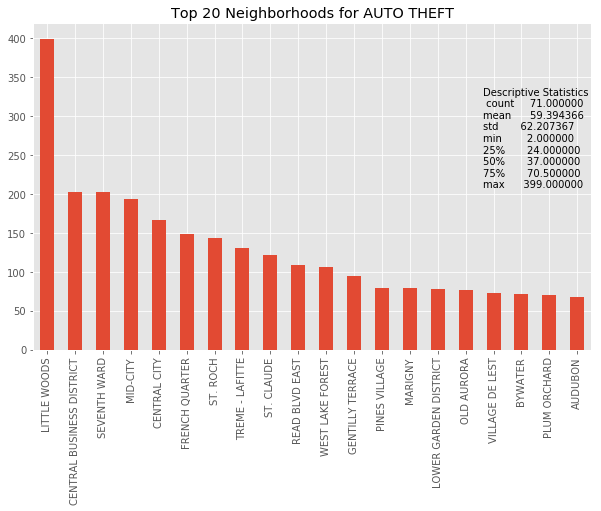

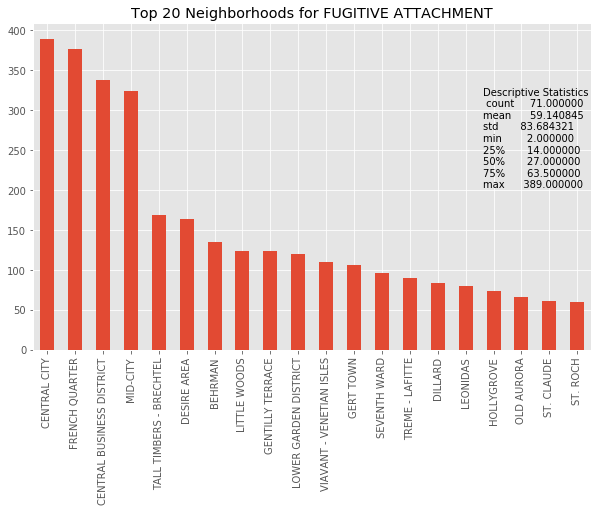

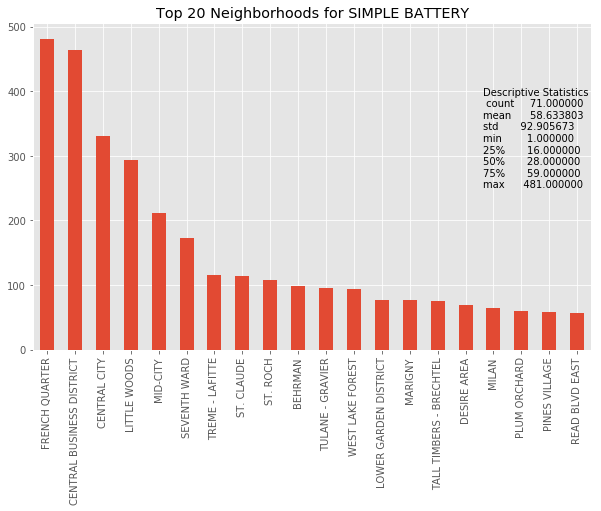

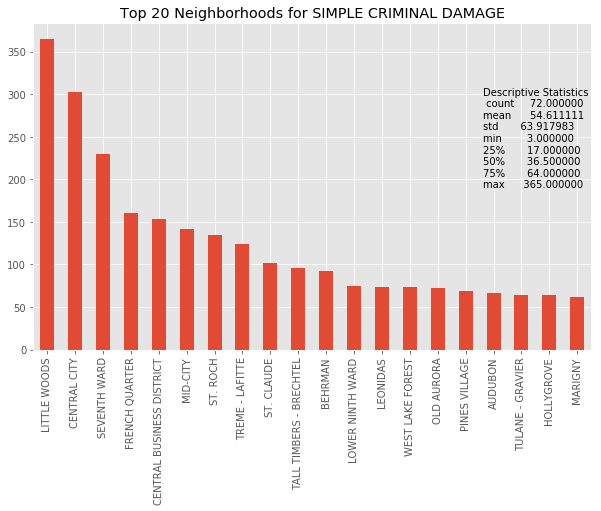

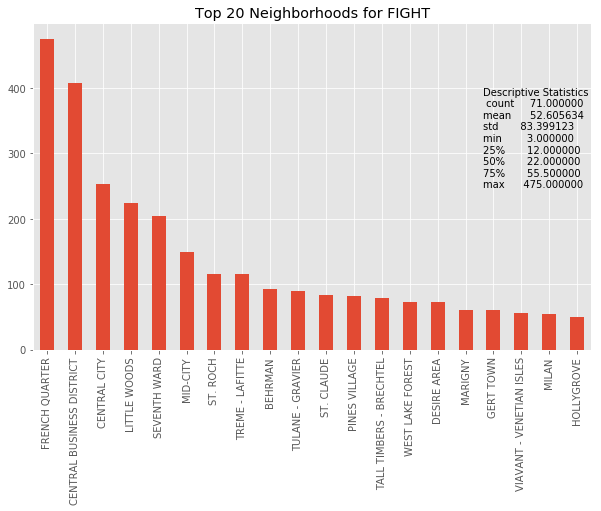

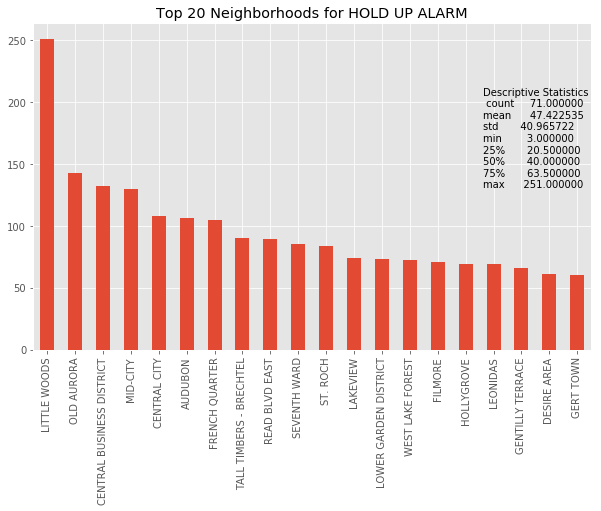

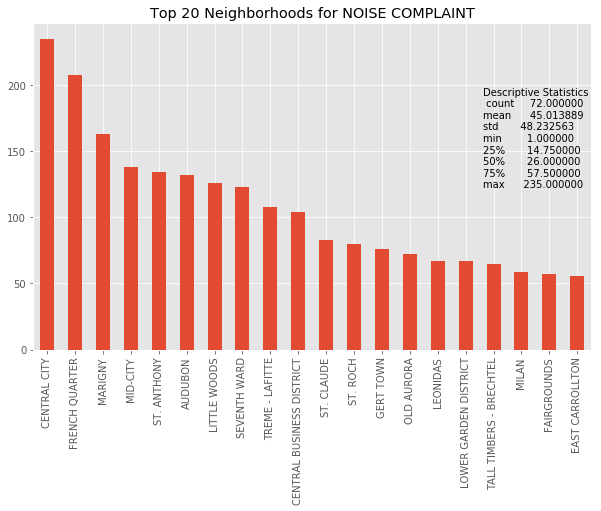

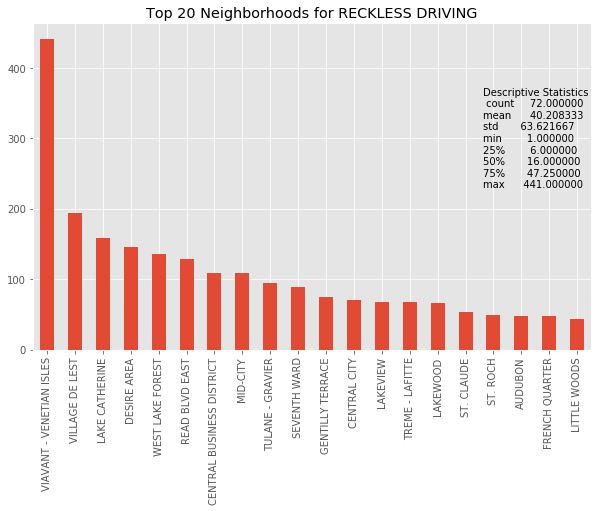

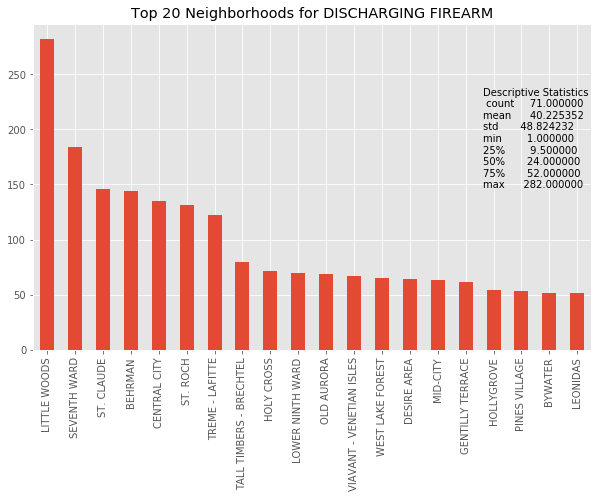

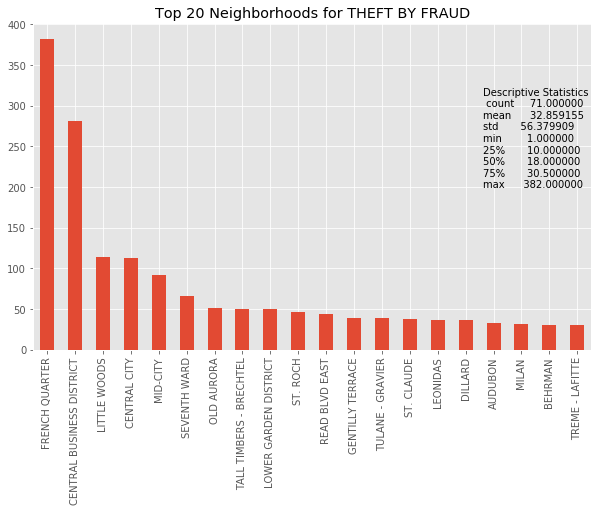

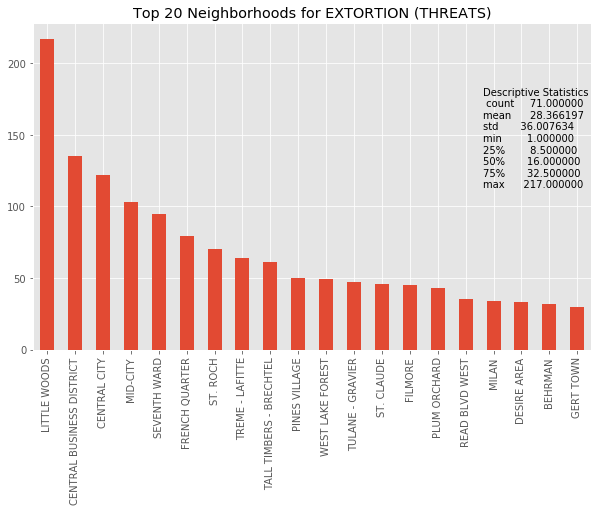

In [27]:
for t in typetotals.head(20).index:
    civildf[civildf['Type']==t].Neighborhood.value_counts().to_frame().head(20).plot(kind='bar', figsize=(10,6), legend=None)
    plt.title('Top 20 Neighborhoods for {}'.format(t))
    plt.figtext(0.75,0.5, 'Descriptive Statistics \n {}'.format(civildf[civildf['Type']==t].Neighborhood.value_counts().describe().to_string()))
    plt.show

<a name="3.1.2"></a>
#### 3.1.2 Frequency Distribution of Incident Totals by Types
---
To see the distribution of incident type occurrence, we'll plot a histogram from the `typetotals` data frame. 

<function matplotlib.pyplot.show(*args, **kw)>

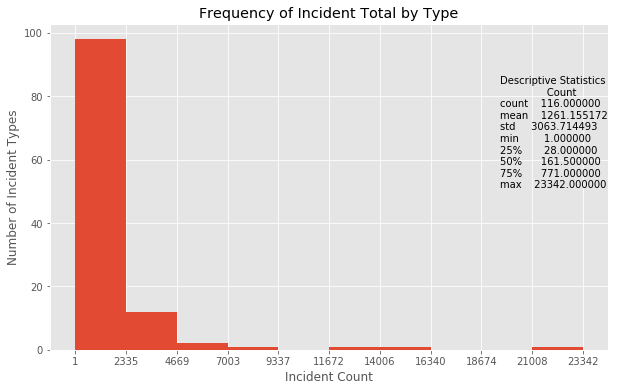

In [16]:
# histogram of incident type occurrence
count1, bin_edges1 = np.histogram(typetotals)
typetotals.plot(kind='hist', figsize=(10, 6), xticks = bin_edges1, legend=None)
plt.ylabel('Number of Incident Types')
plt.xlabel('Incident Count')
plt.figtext(0.75,0.5, 'Descriptive Statistics \n {}'.format(typetotals.describe().to_string()))
plt.title('Frequency of Incident Total by Type')
plt.show

In [17]:
count2, bin_edges2 = np.histogram(typetotals[(typetotals['Count'] >= 28) & (typetotals['Count'] <= 771)])
typetotals[(typetotals['Count'] >= 28) & (typetotals['Count'] <= 771)].plot(kind='hist', figsize=(10, 6), xticks = bin_edges2, legend=None)
plt.ylabel('Number of Incident Types')
plt.xlabel('Incident Count')
plt.title('Quartiles 2 & 3 of Frequency Dist. of Total by Type')
plt.figtext(0.75,0.5, 'Descriptive Statistics \n {}'.format(typetotals[(typetotals['Count'] >= 28) & (typetotals['Count'] <= 771)].describe().to_string()))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<a name="3.1.3"></a>
#### 3.1.3 Top Neighborhoods of Incident Occurrence
---
To get our top neighborhoods of incident occurrence, we can group the incidents from `civildf` by neighborhood and get the total for each. Following that, we can represent this data in a bar chart showing the top 20 neighborhoods of occurrence. We can then explore what incident types occur most in each of these neighborhoods.  

In [8]:
#Dataframe of total incidents per Neighborhood
hoodtotals = civildf.Neighborhood.value_counts().to_frame()
hoodtotals.columns=['Incident Count']
hoodtotals.head()

Incident Count
LITTLE WOODS                        10861
CENTRAL CITY                         9097
CENTRAL BUSINESS DISTRICT            8349
FRENCH QUARTER                       7871
SEVENTH WARD                         6092

In [34]:
# Barchart of neighborhoods with the top 20 incident occurrence
%matplotlib inline
hoodtotals.head(20).plot(kind='bar', figsize=(10, 6), legend=None)
plt.xlabel('Neighborhood')
plt.ylabel('Incident Count')
plt.title('Neighborhood-Safety/Crime-related 911 Calls for top 20 Neighborhoods, New Orleans 2018')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

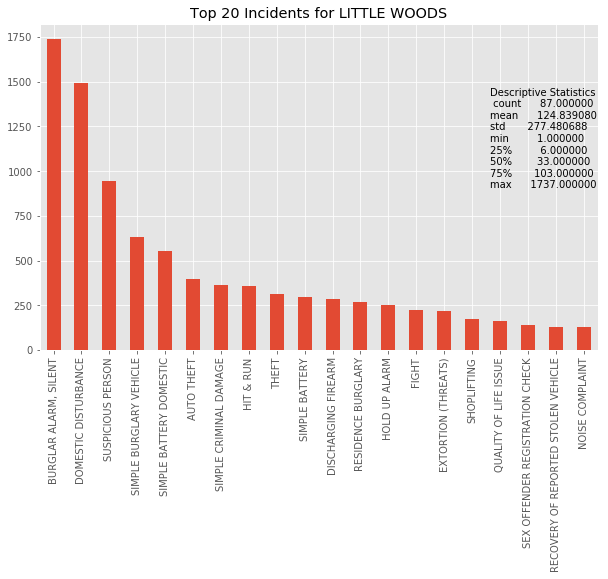

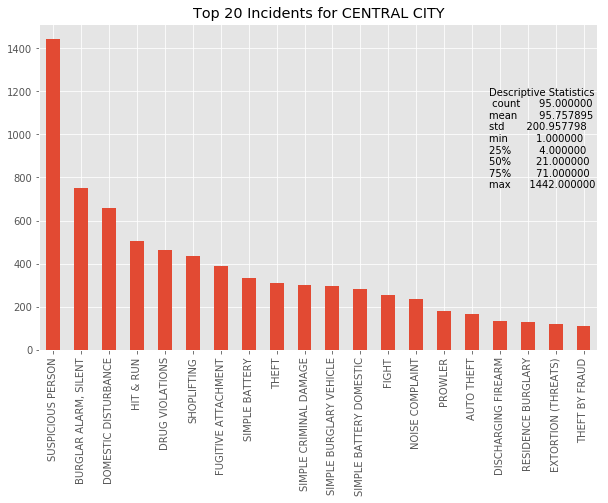

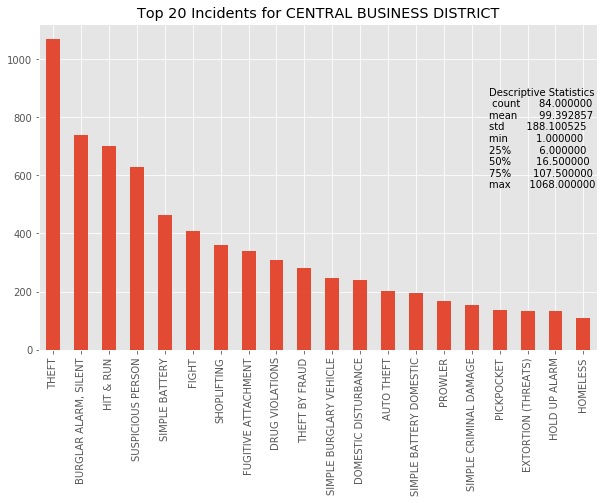

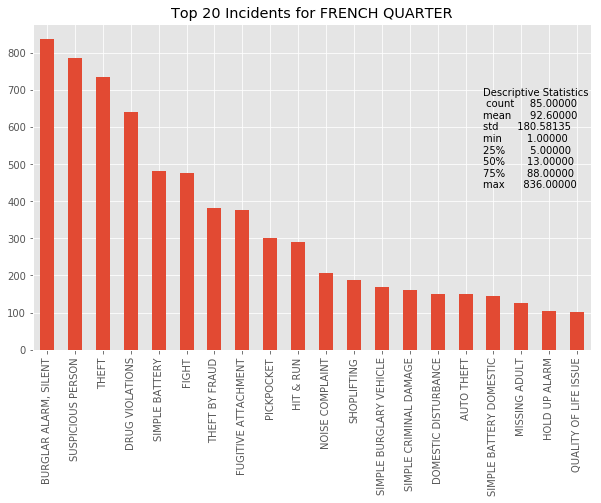

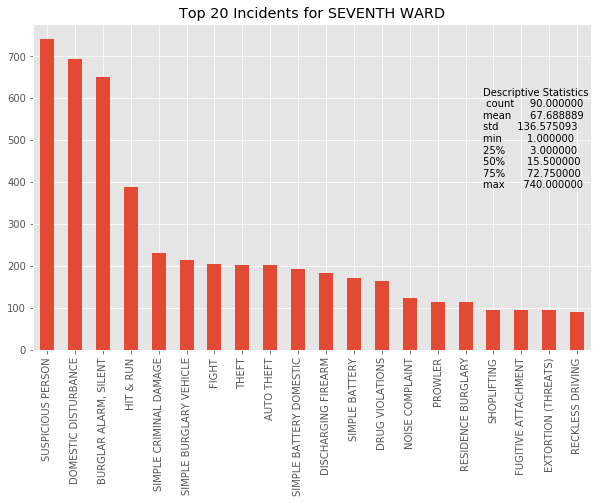

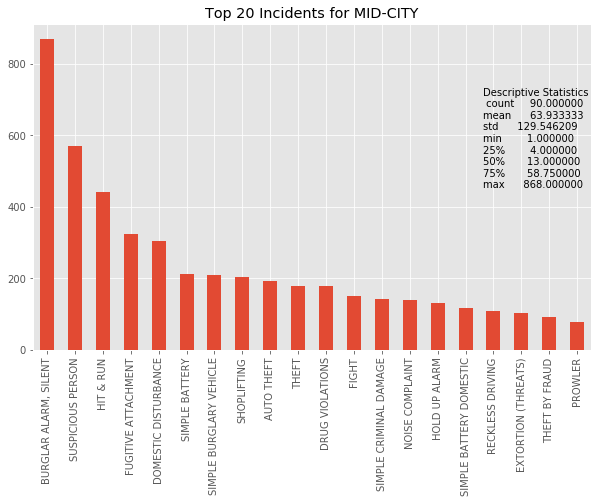

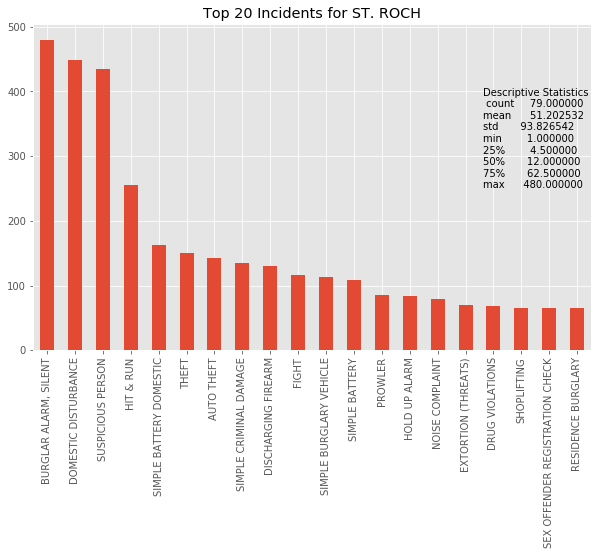

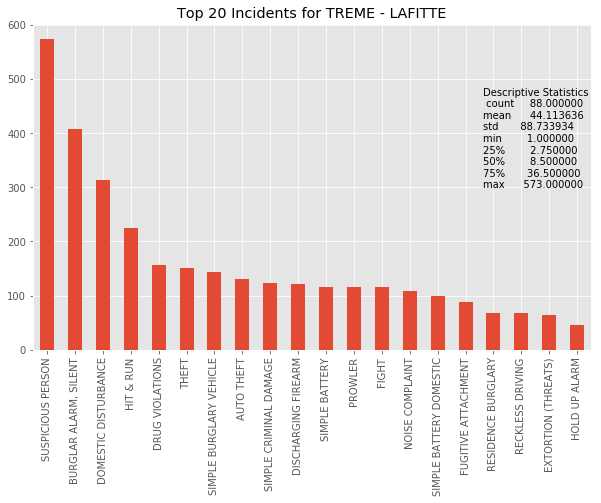

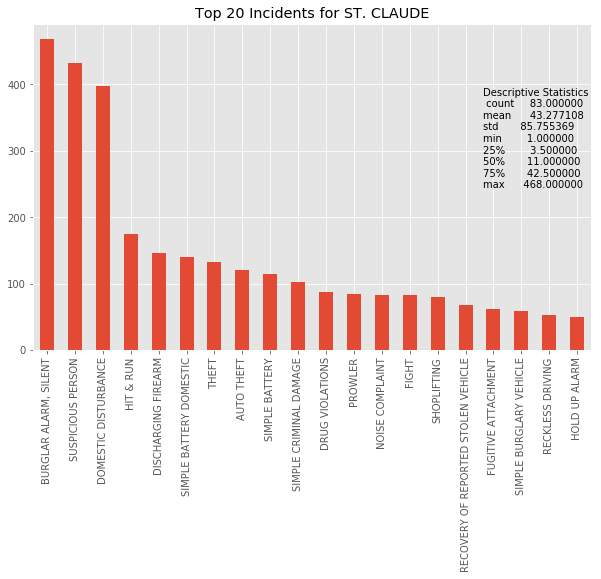

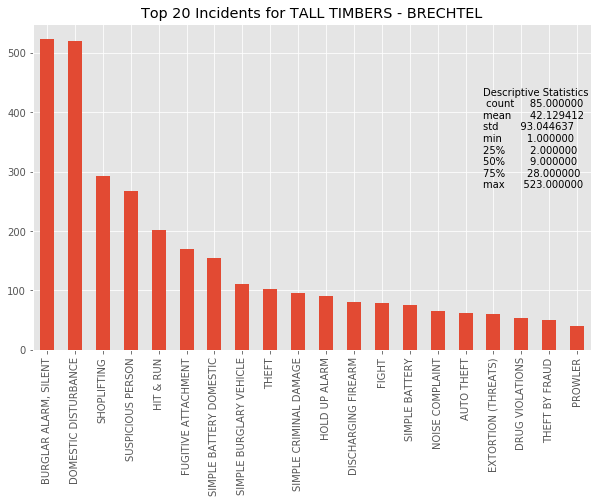

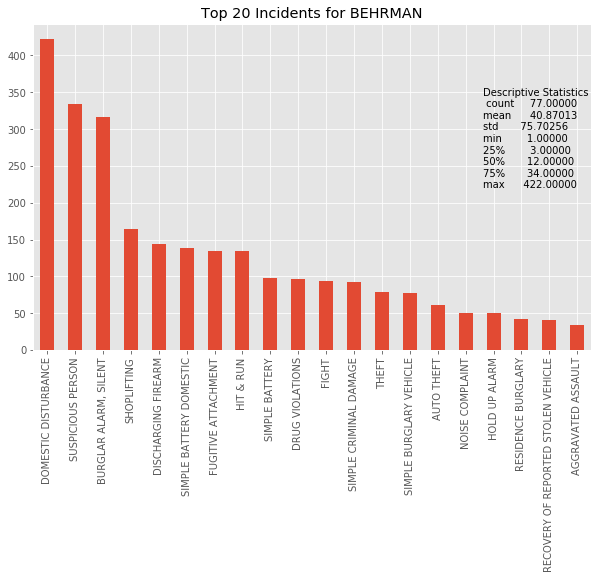

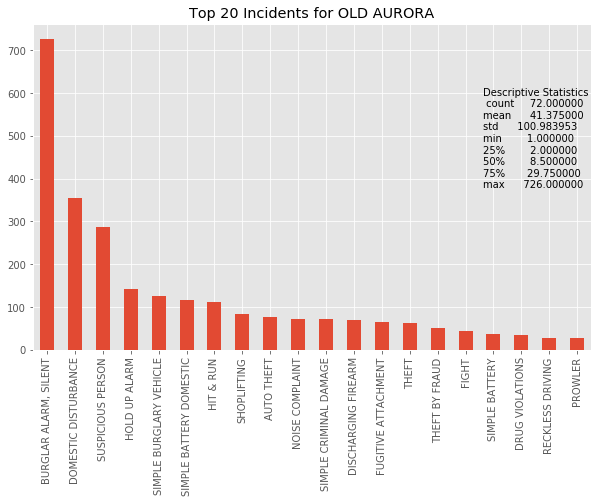

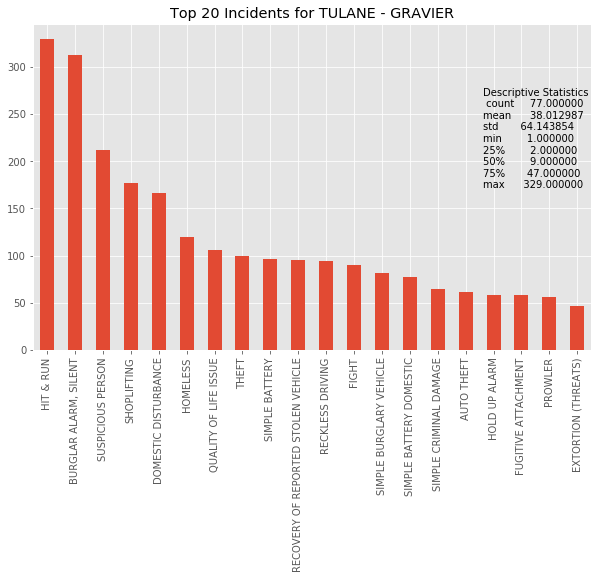

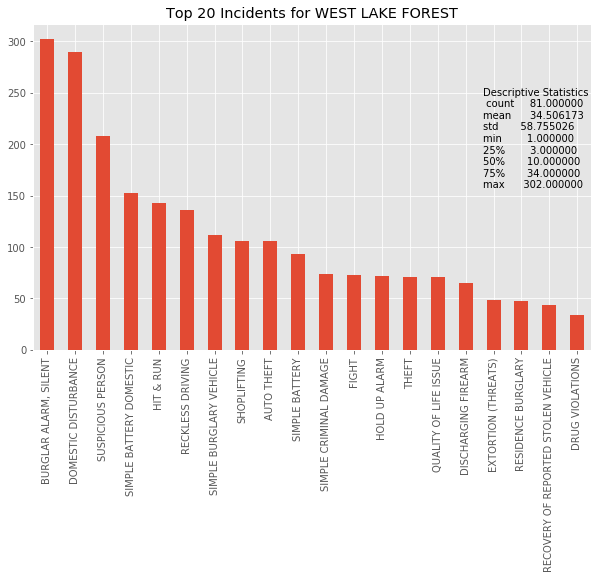

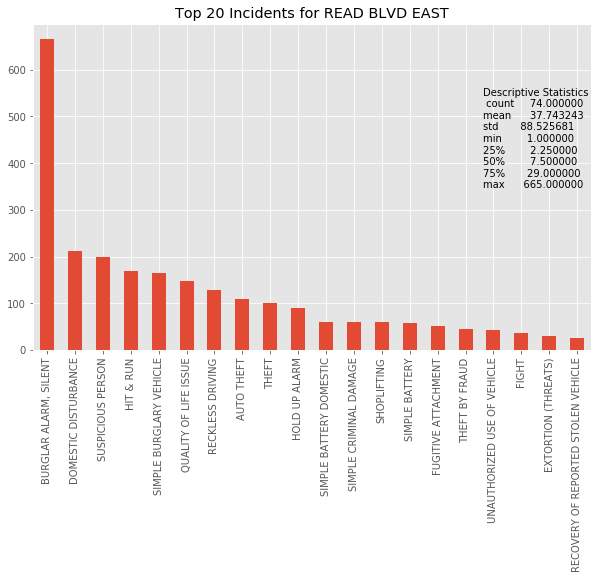

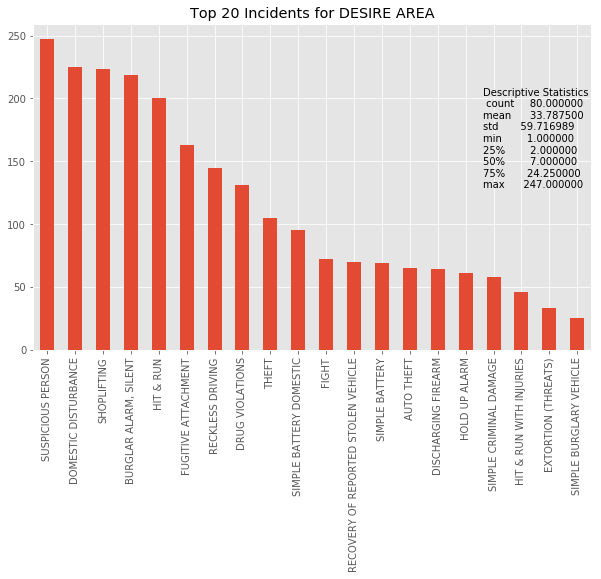

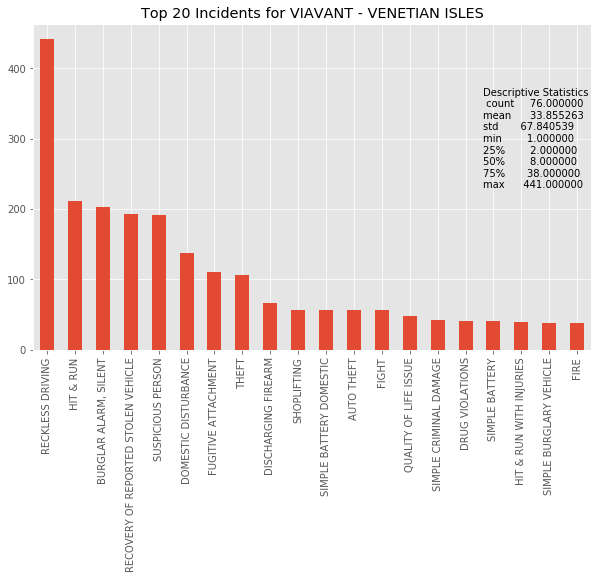

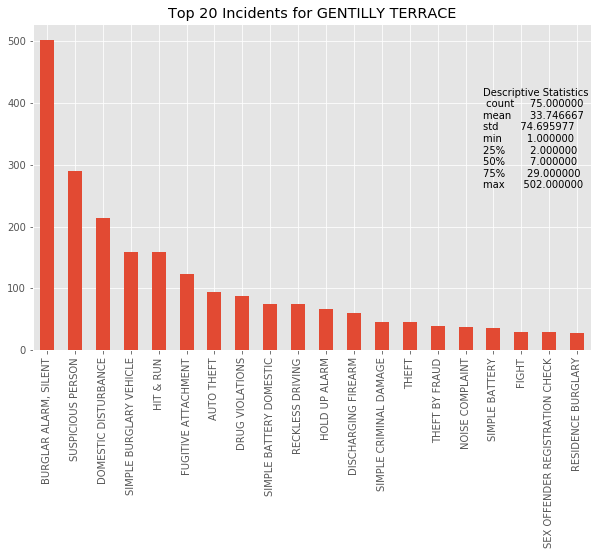

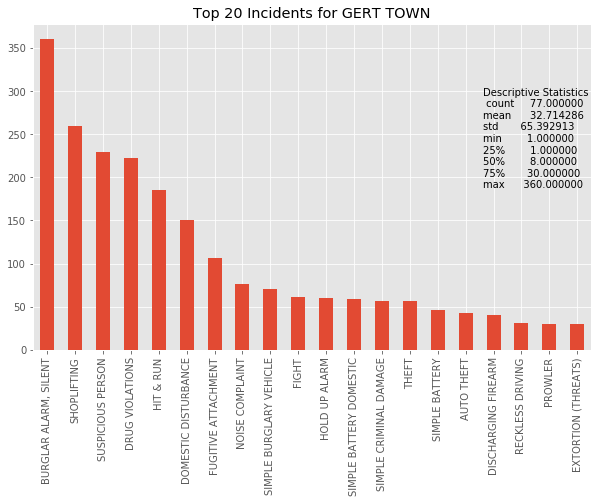

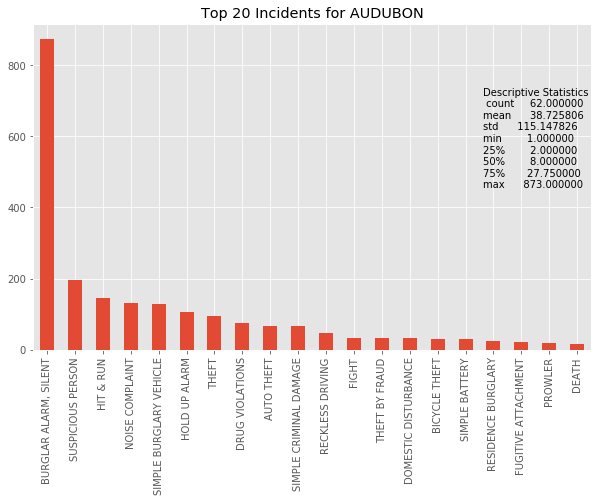

In [37]:
#top 20 incidents by neighborhood and their descriptive stats 
for h in hoodtotals.head(20).index:
    civildf[civildf['Neighborhood']==h].Type.value_counts().to_frame().head(20).plot(kind='bar', figsize=(10,6), legend=None)
    plt.title('Top 20 Incidents for {}'.format(h))
    plt.figtext(0.75,0.5, 'Descriptive Statistics \n {}'.format(civildf[civildf['Neighborhood']==h].Type.value_counts().describe().to_string()))
    plt.show

<a name="3.1.4"></a>
#### 3.1.4 Frequency Distribution of Incident Count by Neighborhoods
---
How many incidents usually occur in neighborhoods. Like above, we'll plot a histogram from the `hoodtotals` data frame.

<function matplotlib.pyplot.show(*args, **kw)>

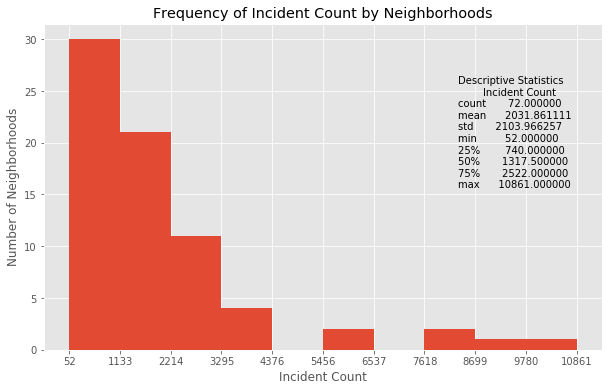

In [13]:
#histogram, showing distribution of incident count among neighborhoods
count, bin_edges = np.histogram(hoodtotals)
hoodtotals.plot(kind='hist', figsize=(10, 6), xticks = bin_edges, legend=None)
plt.ylabel('Number of Neighborhoods')
plt.xlabel('Incident Count')
plt.figtext(0.70,0.5, 'Descriptive Statistics \n {}'.format(hoodtotals.describe().to_string()))
plt.title('Frequency of Incident Count by Neighborhoods')
plt.show

<a name="3.1.5"></a>
#### 3.1.5 Choropleth Map of Incidents in New Orleans by Neighborhood
---
We'll need to use a geojson file of our neighborhood boundary information to generate a choropleth map. This file can be found [here](https://data.nola.gov/api/geospatial/7svi-kqix?method=export&format=GeoJSON "Neighborhood geojson"). A corrected version is also available in the github project folder. Next, we will join our neighborhoods data frame with the hoodtotals data frame to get the neighborhood centroid coordinates.  

In [18]:
# The code was removed by Watson Studio for sharing.

In [9]:
#corrected geojson available in github project folder
nola_geo = r'nola_geojson.json'

In [10]:
#join our neighborhoods dataframe to the hoodtotals
hoodts = neighborhoods.join(hoodtotals, on='Neighborhood')
hoodts.head()

Neighborhood  Longitude   Latitude  Incident Count
0  U.S. NAVAL BASE -90.026093  29.946085             645
1    ALGIERS POINT -90.051606  29.952462             430
2          WHITNEY -90.042357  29.947200             800
3          AUDUBON -90.121450  29.932994            2401
4       OLD AURORA -90.000000  29.924440            2979

In [11]:
# Map of New Orleans Neighborhoods
# New Orleans latitude and longitude values
latitude = 29.951065
longitude = -90.071533

# create map and display it
nola_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# loop through the neighborhoods and add each to the map
for lat, lng, label in zip(neighborhoods.Latitude, neighborhoods.Longitude, neighborhoods.Neighborhood):
    folium.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(nola_map)


# display the map of New Orleans
nola_map

In [12]:
nola_map = folium.Map(location=[latitude, longitude], zoom_start=11)


# generate choropleth map using the neighborhood-safety related incidents in nola by neighborhood
nola_map.choropleth(
    geo_data=nola_geo,
    data=hoodts,
    columns=['Neighborhood', 'Incident Count'],
    key_on='feature.properties.gnocdc_lab',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhood Safety Related Incidents 2018',
    reset=True
)

# loop through the neighborhoods and add each to the map
for lat, lng, hood, count in zip(hoodts.Latitude, hoodts.Longitude, hoodts.Neighborhood, hoodts['Incident Count']):
    folium.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup='{}, {} incidents'.format(hood, count),
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(nola_map)

# display map
nola_map

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


We can also explore this data by quartile or by excluding certain quartiles. By excluding the top quartile, we may produce a map showing more desirable neighborhoods to live in for those moving to or around the city. The top quartile neighborhoods are blacked out in this map. 

In [13]:
#make a list of neighborhoods in each quartile
tophoods = []
upperhoods =[]
lowerhoods = []
bottomhoods = []
for i in civildf.Neighborhood.value_counts()[civildf.Neighborhood.value_counts() > 2522].index:
    tophoods.append(i)
    
for i in civildf.Neighborhood.value_counts()[(civildf.Neighborhood.value_counts() > 1316.5) & (civildf.Neighborhood.value_counts() <= 2522)].index:
    upperhoods.append(i)
    
for i in civildf.Neighborhood.value_counts()[(civildf.Neighborhood.value_counts() > 740) & (civildf.Neighborhood.value_counts() <= 1316.5)].index:
    lowerhoods.append(i)
    
for i in civildf.Neighborhood.value_counts()[civildf.Neighborhood.value_counts() <= 740].index:
    bottomhoods.append(i)

In [14]:
nola_map = folium.Map(location=[latitude, longitude], zoom_start=11)


# generate choropleth map using the neighborhood-safety related incidents in nola by neighborhood
nola_map.choropleth(
    geo_data=nola_geo,
    data=hoodts[~hoodts['Neighborhood'].isin(tophoods)],
    columns=['Neighborhood', 'Incident Count'],
    key_on='feature.properties.gnocdc_lab',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhood Safety Related Incidents 2018, top quartile excluded',
    reset=True
)

# loop through the neighborhoods and add each to the map
for lat, lng, hood, count in zip(hoodts.Latitude, hoodts.Longitude, hoodts.Neighborhood, hoodts['Incident Count']):
    folium.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup='{}, {} incidents'.format(hood, count),
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(nola_map)

# display map
nola_map

#### 3.1.6 Time Series of Incidents by Month
---
For checking incidents by month, our final data frame needs to have the months as the index and the sum totals by neighborhood or incident type as columns. We will make a dataframe for each of these types using the pandas groupby on our timestamp data. 

In [15]:
# monthly time series by neighborhood
df3 = civildf.groupby([civildf.Time.map(lambda t: t.month), 'Neighborhood']).count() #group by month and sum incidents by neighborhood
df3.drop(columns=['Code', 'Type', 'Time', 'Beat', 'Address', 'Zip', 'District'], inplace=True) #drop unnecessary columns
df3.reset_index(inplace=True)
df3.columns=['Month', 'Neighborhood', 'Count'] #rename columns
df3 = df3.pivot(index='Neighborhood', columns='Month', values='Count') #pivot
df3.fillna(value=0, inplace=True) #fill nan values
df3['Total'] = df3.sum(axis=1)
df3.sort_values(['Total'], ascending=False, axis=0, inplace=True)
mhood = df3.drop(columns='Total').transpose()
mhood['Total']=mhood.sum(axis=1)
mhood.head()

#df3.groupby('Month')['Count'].sum().plot(kind=) #get  total incidents by month


Neighborhood  LITTLE WOODS  CENTRAL CITY  CENTRAL BUSINESS DISTRICT  \
Month                                                                 
1                    798.0         736.0                      614.0   
2                    838.0         773.0                      776.0   
3                    887.0         717.0                      634.0   
4                    912.0         702.0                      636.0   
5                    995.0         861.0                      713.0   

Neighborhood  FRENCH QUARTER  SEVENTH WARD  MID-CITY  ST. ROCH  \
Month                                                            
1                      646.0         465.0     495.0     319.0   
2                      776.0         463.0     455.0     347.0   
3                      634.0         562.0     504.0     329.0   
4                      654.0         531.0     474.0     375.0   
5                      617.0         569.0     497.0     374.0   

Neighborhood  TREME - LAFITTE  ST. CLAUDE  TALL TIMBERS - BRECHTEL  ...  \
Month                                                               ...   
1                       330.0       268.0                    302.0  ...   
2                       378.0       304.0                    274.0  ...   
3                       348.0       274.0                    304.0  ...   
4                       323.0       329.0                    301.0  ...   
5                       329.0       336.0                    325.0  ...   

Neighborhood  NAVARRE  GARDEN DISTRICT  PONTCHARTRAIN PARK  LAKEWOOD  \
Month                                                                  
1                34.0             57.0                33.0      39.0   
2                45.0             46.0                43.0      38.0   
3                36.0             64.0                48.0      40.0   
4                48.0             26.0                40.0      46.0   
5                32.0             51.0                30.0      47.0   

Neighborhood  ALGIERS POINT  LAKE CATHERINE  FISCHER DEV  BLACK PEARL  \
Month                                                                   
1                      50.0            31.0         21.0         18.0   
2                      34.0            25.0         32.0         26.0   
3                      47.0            33.0         38.0         17.0   
4                      34.0            27.0         27.0         17.0   
5                      42.0            26.0         21.0         30.0   

Neighborhood  FLORIDA DEV    Total  
Month                               
1                     8.0  11511.0  
2                     0.0  11789.0  
3                     6.0  12445.0  
4                     4.0  12182.0  
5                     7.0  12937.0  

[5 rows x 73 columns]

In [16]:
#time series grouped by incident type
df4 = civildf.groupby([civildf.Time.map(lambda t: t.month), 'Type']).count() #group by month and sum incidents by neighborhood
df4.drop(columns=['Code', 'Neighborhood', 'Time', 'Beat', 'Address', 'Zip', 'District'], inplace=True) #drop unnecessary columns
df4.reset_index(inplace=True)
df4.columns=['Month', 'Type', 'Count'] #rename columns
df4 = df4.pivot(index='Type', columns='Month', values='Count') #pivot to get months as columns
df4.fillna(value=0, inplace=True) #fill nan values
df4['Total'] = df4.sum(axis=1)
df4.sort_values(['Total'], ascending=False, axis=0, inplace=True)
mincident = df4.drop(columns='Total').transpose()
mincident['Total']=mincident.sum(axis=1)
mincident.head()

Type   BURGLAR ALARM, SILENT  SUSPICIOUS PERSON  DOMESTIC DISTURBANCE  \
Month                                                                   
1                     2297.0             1111.0                 976.0   
2                     1785.0             1222.0                 985.0   
3                     2090.0             1250.0                1027.0   
4                     1952.0             1231.0                1144.0   
5                     2204.0             1312.0                1144.0   

Type   HIT & RUN  THEFT  SIMPLE BURGLARY VEHICLE  DRUG VIOLATIONS  \
Month                                                               
1          601.0  392.0                    321.0            280.0   
2          697.0  433.0                    414.0            328.0   
3          771.0  502.0                    377.0            416.0   
4          719.0  515.0                    390.0            368.0   
5          765.0  516.0                    418.0            438.0   

Type   SIMPLE BATTERY DOMESTIC  SHOPLIFTING  AUTO THEFT  ...  \
Month                                                    ...   
1                        368.0        295.0       292.0  ...   
2                        406.0        278.0       350.0  ...   
3                        381.0        340.0       314.0  ...   
4                        419.0        330.0       338.0  ...   
5                        416.0        346.0       387.0  ...   

Type   HOSTAGE SITUATION  SAFE BURGLARY  HOMICIDE DOMESTIC  \
Month                                                        
1                    0.0            0.0                0.0   
2                    0.0            0.0                0.0   
3                    1.0            0.0                0.0   
4                    0.0            0.0                0.0   
5                    0.0            0.0                0.0   

Type   DESECRATION OF GRAVES  UNATTENDED PACKAGE  PANDERING  ASSET SEIZURE  \
Month                                                                        
1                        0.0                 0.0        0.0            0.0   
2                        0.0                 0.0        0.0            0.0   
3                        0.0                 0.0        0.0            0.0   
4                        0.0                 0.0        0.0            0.0   
5                        0.0                 0.0        0.0            0.0   

Type   AGGRAVATED ESCAPE  SIMPLE ARSON DOMESTIC    Total  
Month                                                     
1                    0.0                    0.0  11511.0  
2                    0.0                    0.0  11789.0  
3                    1.0                    0.0  12445.0  
4                    0.0                    1.0  12182.0  
5                    0.0                    0.0  12937.0  

[5 rows x 117 columns]

<a name="3.1.6"></a>
First, let's examine our incident totals by month.

<function matplotlib.pyplot.show(*args, **kw)>

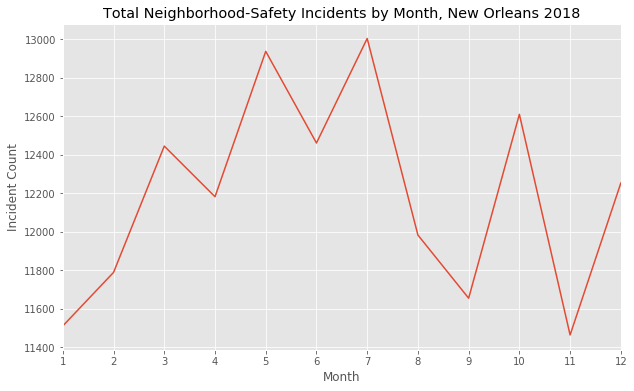

In [17]:
mincident.Total.plot(kind='line', figsize=(10, 6), xticks=np.linspace(1, 12, num=12))
plt.ylabel('Incident Count')
plt.title('Total Neighborhood-Safety Incidents by Month, New Orleans 2018')
plt.show

In [37]:
# what was higher than average, what was lower by 1.25 std deviations 
mincident[(mincident['Total']>(mincident.describe().loc['mean', 'Total']+1.25*(mincident.describe().loc['std', 'Total']))) | (mincident['Total']<(mincident.describe().loc['mean', 'Total']-1.25*(mincident.describe().loc['std', 'Total'])))]

Type   BURGLAR ALARM, SILENT  SUSPICIOUS PERSON  DOMESTIC DISTURBANCE  \
Month                                                                   
1                     2297.0             1111.0                 976.0   
5                     2204.0             1312.0                1144.0   
7                     2044.0             1292.0                1092.0   
11                    1778.0             1124.0                 878.0   

Type   HIT & RUN  THEFT  SIMPLE BURGLARY VEHICLE  DRUG VIOLATIONS  \
Month                                                               
1          601.0  392.0                    321.0            280.0   
5          765.0  516.0                    418.0            438.0   
7          639.0  544.0                    556.0            370.0   
11         705.0  460.0                    532.0            379.0   

Type   SIMPLE BATTERY DOMESTIC  SHOPLIFTING  AUTO THEFT  ...  \
Month                                                    ...   
1                        368.0        295.0       292.0  ...   
5                        416.0        346.0       387.0  ...   
7                        392.0        463.0       376.0  ...   
11                       318.0        323.0       382.0  ...   

Type   HOSTAGE SITUATION  SAFE BURGLARY  HOMICIDE DOMESTIC  \
Month                                                        
1                    0.0            0.0                0.0   
5                    0.0            0.0                0.0   
7                    0.0            0.0                0.0   
11                   0.0            0.0                0.0   

Type   DESECRATION OF GRAVES  UNATTENDED PACKAGE  PANDERING  ASSET SEIZURE  \
Month                                                                        
1                        0.0                 0.0        0.0            0.0   
5                        0.0                 0.0        0.0            0.0   
7                        0.0                 1.0        0.0            0.0   
11                       0.0                 0.0        1.0            1.0   

Type   AGGRAVATED ESCAPE  SIMPLE ARSON DOMESTIC    Total  
Month                                                     
1                    0.0                    0.0  11511.0  
5                    0.0                    0.0  12937.0  
7                    0.0                    0.0  13004.0  
11                   0.0                    0.0  11464.0  

[4 rows x 117 columns]

We can also examine specific incidents over the year, see below.

<function matplotlib.pyplot.show(*args, **kw)>

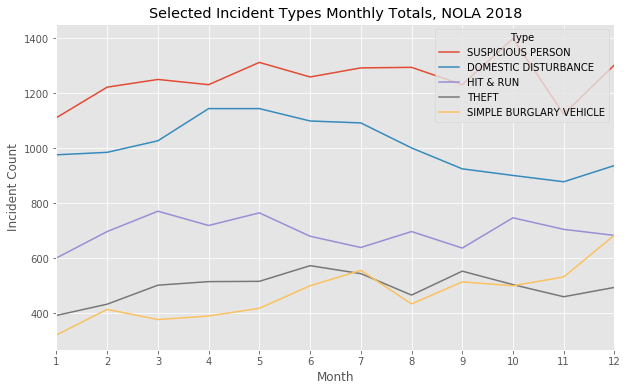

In [44]:
mincident.iloc[:, 1:6].plot(kind='line', figsize=(10,6),xticks=np.linspace(1, 12, num=12))
plt.ylabel('Incident Count')
plt.title('Selected Incident Types Monthly Totals, NOLA 2018')
plt.show

Next, we'll plot a segment of our neighborhood incident totals over the year. Since 72 neighborhoods is too busy for one graph, let's look at the median neighborhoods of each quartile of neighborhoods by total incident count. 

<function matplotlib.pyplot.show(*args, **kw)>

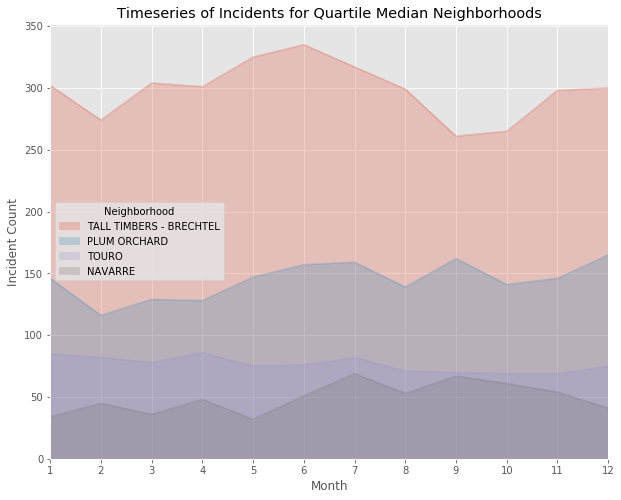

In [125]:
#time series of median neighborhoods per quartile
mhood[[tophoods[9], upperhoods[9], lowerhoods[8], bottomhoods[10]]].plot(kind='area', figsize=(10, 8), xticks=np.linspace(1, 12, num=12), stacked=False, alpha=0.25)
plt.ylabel('Incident Count')
plt.title('Timeseries of Incidents for Quartile Median Neighborhoods')
plt.show

Using the describe() function, we can see the descriptive statistics for Incidents based on Neighborhood or Type over the year.

In [18]:
mincident.describe()

Type   BURGLAR ALARM, SILENT  SUSPICIOUS PERSON  DOMESTIC DISTURBANCE  \
count              12.000000          12.000000             12.000000   
mean             1945.166667        1252.333333           1009.083333   
std               212.605411          79.356885             92.715065   
min              1584.000000        1111.000000            878.000000   
25%              1783.250000        1228.750000            934.000000   
50%              1921.000000        1254.500000            993.000000   
75%              2102.250000        1296.250000           1093.750000   
max              2297.000000        1399.000000           1144.000000   

Type    HIT & RUN       THEFT  SIMPLE BURGLARY VEHICLE  DRUG VIOLATIONS  \
count   12.000000   12.000000                12.000000        12.000000   
mean   695.083333  496.000000               470.000000       374.833333   
std     52.021776   51.635083                97.774323        48.814739   
min    601.000000  392.000000               321.000000       280.000000   
25%    669.750000  464.500000               408.000000       355.750000   
50%    697.000000  503.000000               467.000000       374.500000   
75%    726.000000  523.000000               518.500000       399.500000   
max    771.000000  573.000000               684.000000       454.000000   

Type   SIMPLE BATTERY DOMESTIC  SHOPLIFTING  AUTO THEFT  ...  \
count                12.000000    12.000000   12.000000  ...   
mean                368.583333   361.666667  351.416667  ...   
std                  35.266410    55.463884   40.333740  ...   
min                 318.000000   278.000000  284.000000  ...   
25%                 342.000000   328.250000  325.250000  ...   
50%                 370.500000   355.000000  363.000000  ...   
75%                 395.500000   384.000000  378.250000  ...   
max                 419.000000   463.000000  412.000000  ...   

Type   HOSTAGE SITUATION  SAFE BURGLARY  HOMICIDE DOMESTIC  \
count          12.000000      12.000000          12.000000   
mean            0.166667       0.083333           0.083333   
std             0.389249       0.288675           0.288675   
min             0.000000       0.000000           0.000000   
25%             0.000000       0.000000           0.000000   
50%             0.000000       0.000000           0.000000   
75%             0.000000       0.000000           0.000000   
max             1.000000       1.000000           1.000000   

Type   DESECRATION OF GRAVES  UNATTENDED PACKAGE  PANDERING  ASSET SEIZURE  \
count              12.000000           12.000000  12.000000      12.000000   
mean                0.083333            0.083333   0.083333       0.083333   
std                 0.288675            0.288675   0.288675       0.288675   
min                 0.000000            0.000000   0.000000       0.000000   
25%                 0.000000            0.000000   0.000000       0.000000   
50%                 0.000000            0.000000   0.000000       0.000000   
75%                 0.000000            0.000000   0.000000       0.000000   
max                 1.000000            1.000000   1.000000       1.000000   

Type   AGGRAVATED ESCAPE  SIMPLE ARSON DOMESTIC         Total  
count          12.000000              12.000000     12.000000  
mean            0.083333               0.083333  12191.166667  
std             0.288675               0.288675    523.752168  
min             0.000000               0.000000  11464.000000  
25%             0.000000               0.000000  11755.500000  
50%             0.000000               0.000000  12217.500000  
75%             0.000000               0.000000  12498.250000  
max             1.000000               1.000000  13004.000000  

[8 rows x 117 columns]

In [19]:
mhood.describe()

Neighborhood  LITTLE WOODS  CENTRAL CITY  CENTRAL BUSINESS DISTRICT  \
count            12.000000     12.000000                  12.000000   
mean            905.083333    758.083333                 695.750000   
std              76.598669     57.310095                  52.846476   
min             777.000000    661.000000                 614.000000   
25%             843.250000    713.250000                 654.000000   
50%             922.500000    760.500000                 703.500000   
75%             956.250000    799.000000                 719.250000   
max            1006.000000    861.000000                 777.000000   

Neighborhood  FRENCH QUARTER  SEVENTH WARD    MID-CITY    ST. ROCH  \
count              12.000000     12.000000   12.000000   12.000000   
mean              655.916667    507.666667  479.500000  337.083333   
std                59.408384     43.608451   25.083497   24.762355   
min               600.000000    426.000000  434.000000  299.000000   
25%               617.750000    480.750000  464.000000  321.250000   
50%               634.000000    511.000000  487.000000  330.500000   
75%               658.750000    537.750000  495.500000  352.250000   
max               776.000000    569.000000  518.000000  375.000000   

Neighborhood  TREME - LAFITTE  ST. CLAUDE  TALL TIMBERS - BRECHTEL  ...  \
count               12.000000   12.000000                12.000000  ...   
mean               323.500000  299.333333               298.416667  ...   
std                 25.025442   28.298196                22.476082  ...   
min                291.000000  250.000000               261.000000  ...   
25%                302.000000  279.250000               292.000000  ...   
50%                325.500000  301.500000               300.500000  ...   
75%                332.250000  318.500000               307.250000  ...   
max                378.000000  341.000000               335.000000  ...   

Neighborhood    NAVARRE  GARDEN DISTRICT  PONTCHARTRAIN PARK   LAKEWOOD  \
count         12.000000        12.000000           12.000000  12.000000   
mean          49.250000        43.333333           41.083333  38.416667   
std           12.344487        10.982079            5.806866   5.316498   
min           32.000000        26.000000           30.000000  29.000000   
25%           39.750000        38.250000           39.000000  36.000000   
50%           49.500000        41.000000           41.500000  38.500000   
75%           55.750000        50.250000           45.500000  40.500000   
max           69.000000        64.000000           48.000000  47.000000   

Neighborhood  ALGIERS POINT  LAKE CATHERINE  FISCHER DEV  BLACK PEARL  \
count             12.000000       12.000000    12.000000    12.000000   
mean              35.833333       32.416667    27.166667    19.666667   
std               10.373334        5.822501     6.249848     6.005048   
min               20.000000       25.000000    18.000000    11.000000   
25%               26.750000       29.250000    22.500000    16.250000   
50%               34.000000       31.500000    26.000000    19.500000   
75%               45.500000       34.000000    32.500000    24.000000   
max               50.000000       45.000000    38.000000    30.000000   

Neighborhood  FLORIDA DEV         Total  
count           12.000000     12.000000  
mean             4.333333  12191.166667  
std              2.348436    523.752168  
min              0.000000  11464.000000  
25%              3.000000  11755.500000  
50%              4.500000  12217.500000  
75%              6.000000  12498.250000  
max              8.000000  13004.000000  

[8 rows x 73 columns]

<a name="3.1.7"></a>
#### 3.1.7 Top Venue Types and Frequencies
---
We'll now use Foursquare API to retrieve the top 100 venues within a 750 m radius of each neighborhood centroid from the `neighborhoods` dataframe. Please note that this will not retrieve all venues and it will not be exhaustive of a neighborhood's boundaries due to the methods available with foursquare and their data that is freely available. Afterward, we'll see what the top venue types retrieved for New Orleans are.

**Foursquare Credentials (hidden)**

In [52]:
# The code was removed by Watson Studio for sharing.

In [21]:
#function for getting nearby venues
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [180]:
nola_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

U.S. NAVAL BASE
ALGIERS POINT
WHITNEY
AUDUBON
OLD AURORA
B. W. COOPER
BAYOU ST. JOHN
BEHRMAN
BLACK PEARL
BROADMOOR
MARLYVILLE - FONTAINEBLEAU
GERT TOWN
MID-CITY
ST. CLAUDE
CENTRAL BUSINESS DISTRICT
FRENCH QUARTER
CENTRAL CITY
LAKE CATHERINE
VILLAGE DE LEST
VIAVANT - VENETIAN ISLES
NEW AURORA - ENGLISH TURN
TALL TIMBERS - BRECHTEL
FISCHER DEV
McDONOGH
LOWER GARDEN DISTRICT
ST. THOMAS DEV
EAST RIVERSIDE
IRISH CHANNEL
TOURO
MILAN
UPTOWN
WEST RIVERSIDE
EAST CARROLLTON
FRERET
GARDEN DISTRICT
LEONIDAS
HOLLYGROVE
TULANE - GRAVIER
TREME - LAFITTE
SEVENTH WARD
MARIGNY
ST. ROCH
DIXON
LAKEWOOD
NAVARRE
CITY PARK
LAKEVIEW
WEST END
LAKESHORE - LAKE VISTA
FILMORE
ST. BERNARD AREA
DILLARD
ST. ANTHONY
LAKE TERRACE & OAKS
MILNEBURG
PONTCHARTRAIN PARK
GENTILLY WOODS
GENTILLY TERRACE
DESIRE AREA
FLORIDA AREA
FLORIDA DEV
LOWER NINTH WARD
BYWATER
HOLY CROSS
PINES VILLAGE
PLUM ORCHARD
READ BLVD WEST
READ BLVD EAST
WEST LAKE FOREST
LITTLE WOODS
FAIRGROUNDS
IBERVILLE


**Please note**: Foursquare was unable to return any venues for 2 neighborhoods--Village de Lest and Viavant - Venetian Isles. These will be excluded for k-means venue analysis. 

In [181]:
#neighborhoods with no venues retrieved by Foursquare
neighborhoods[~neighborhoods['Neighborhood'].isin(nola_venues.groupby('Neighborhood').count().index)]

Neighborhood  Longitude   Latitude
18           VILLAGE DE LEST -89.901123  30.073254
19  VIAVANT - VENETIAN ISLES -89.945755  30.003112

Foursquare reached the limit set for 4 neighborhoods: Marigny, Iberville, Central Business District, and French Quarter. For others, it only retrieved a handful of venues. Lake Catherine only has 1.

In [182]:
nola_venues.shape

(1683, 7)

In [128]:
nola_venues['Neighborhood'].value_counts().to_frame().head()

Neighborhood
IBERVILLE                           100
CENTRAL BUSINESS DISTRICT           100
MARIGNY                             100
FRENCH QUARTER                      100
EAST CARROLLTON                      84

In [131]:
nola_venues['Neighborhood'].value_counts().to_frame().tail()

Neighborhood
READ BLVD WEST                        4
NEW AURORA - ENGLISH TURN             4
PLUM ORCHARD                          4
WHITNEY                               4
LAKESHORE - LAKE VISTA                4

In [132]:
venue_types = nola_venues.groupby('Venue Category').count()
venue_types.drop(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude'], inplace=True)
venue_types.columns=['Count']
venue_types = venue_types.sort_values(by='Count', ascending=False)
venue_types.head()

Count
Venue Category                  
Bar                          106
Hotel                         61
Coffee Shop                   56
Cajun / Creole Restaurant     53
Pizza Place                   48

<function matplotlib.pyplot.show(*args, **kw)>

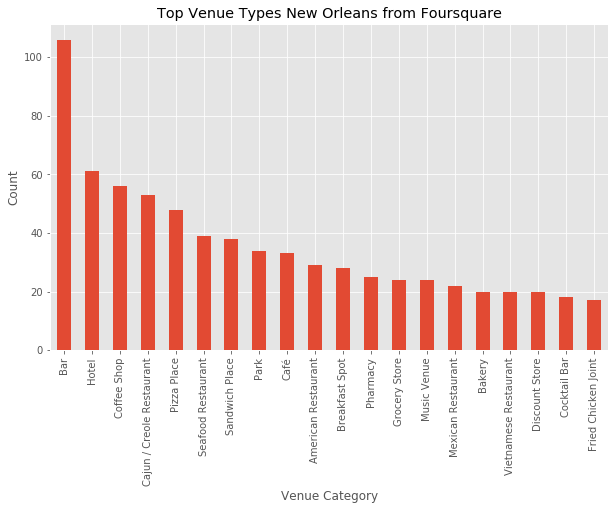

In [133]:
venue_types.head(20).plot(kind='bar', figsize = (10,6), legend=None)
plt.ylabel('Count')
plt.title('Top Venue Types New Orleans from Foursquare')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

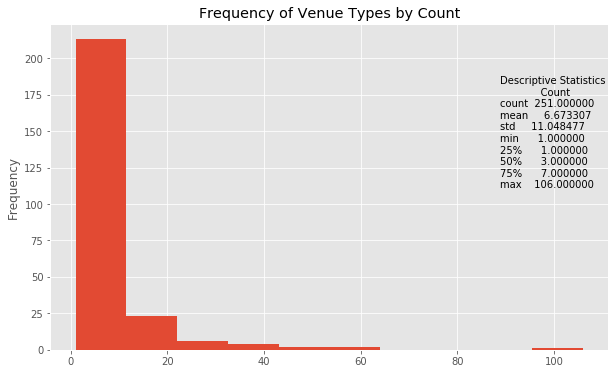

In [134]:
venue_types.plot(kind='hist', figsize = (10,6), legend=None)
plt.figtext(0.75,0.5, 'Descriptive Statistics \n {}'.format(venue_types.describe().to_string()))
plt.title('Frequency of Venue Types by Count')
plt.show

<a name="k-means"></a>
### 3.2 K-Means
---
Data must first be prepared with neighborhoods in the index and venue type/incident type in the column fields with values being normalized incident frequency/venue frequency before we can complete our k-means clustering. We'll use one-hot encoding on the `nola_venues` and `civildf` data frames then group by neighborhood while using the mean function to achieve our target data structure. 

Neighborhoods with very little data will cause trouble for K-means, so we'll drop those with 4 or fewer venues before starting. 

In [281]:
#nola_venues[nola_venues['Neihborhood'] 
ven_counts = nola_venues['Neighborhood'].value_counts().to_frame()
ven_counts.columns=['Count']
ven_counts[ven_counts['Count'] < 4].index
nola_venues = nola_venues[~nola_venues['Neighborhood'].isin(ven_counts[ven_counts['Count'] < 5].index)]
nola_venues.reset_index(inplace=True)
nola_venues.drop(columns='index', inplace=True)
nola_venues.tail()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
1642    IBERVILLE              29.959499              -90.073686   
1643    IBERVILLE              29.959499              -90.073686   
1644    IBERVILLE              29.959499              -90.073686   
1645    IBERVILLE              29.959499              -90.073686   
1646    IBERVILLE              29.959499              -90.073686   

                                  Venue  Venue Latitude  Venue Longitude  \
1642             Tropical Isle Original       29.957844       -90.066266   
1643                       Congo Square       29.964708       -90.070427   
1644               The Art Of Dr. Seuss       29.955154       -90.067988   
1645  The Bayou Burger & Sports Company       29.957177       -90.067000   
1646               Little Tropical Isle       29.956918       -90.067190   

     Venue Category  
1642            Bar  
1643          Plaza  
1644    Art Gallery  
1645   Burger Joint  
1646            Bar

In [232]:
# one hot encoding
venues_onehot = pd.get_dummies(nola_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe, notice that neighborhood was a venue category so we need a different name
venues_onehot['Neighborhoods'] = nola_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

#group by neighborhood and get venue type frequency
venues_grouped = venues_onehot.groupby('Neighborhoods').mean().reset_index()
venues_grouped.head()


Neighborhoods  Accessories Store  American Restaurant  Antique Shop  \
0   ALGIERS POINT                0.0             0.000000           0.0   
1         AUDUBON                0.0             0.000000           0.0   
2    B. W. COOPER                0.0             0.000000           0.0   
3  BAYOU ST. JOHN                0.0             0.021739           0.0   
4         BEHRMAN                0.0             0.000000           0.0   

   Art Gallery  Art Museum  Arts & Crafts Store  Asian Restaurant  \
0         0.00    0.000000             0.037037          0.000000   
1         0.00    0.000000             0.000000          0.000000   
2         0.05    0.000000             0.000000          0.000000   
3         0.00    0.000000             0.000000          0.021739   
4         0.00    0.166667             0.000000          0.000000   

   Athletics & Sports  Automotive Shop  ...  Video Store  \
0                 0.0              0.0  ...          0.0   
1                 0.0              0.0  ...          0.0   
2                 0.0              0.0  ...          0.0   
3                 0.0              0.0  ...          0.0   
4                 0.0              0.0  ...          0.0   

   Vietnamese Restaurant  Warehouse Store  Whisky Bar  Wine Bar  Wine Shop  \
0                    0.0              0.0         0.0  0.000000   0.000000   
1                    0.0              0.0         0.0  0.000000   0.000000   
2                    0.0              0.0         0.0  0.000000   0.050000   
3                    0.0              0.0         0.0  0.043478   0.021739   
4                    0.0              0.0         0.0  0.000000   0.000000   

   Winery  Wings Joint  Women's Store  Yoga Studio  
0     0.0     0.037037            0.0          0.0  
1     0.0     0.000000            0.0          0.0  
2     0.0     0.050000            0.0          0.0  
3     0.0     0.000000            0.0          0.0  
4     0.0     0.000000            0.0          0.0  

[5 rows x 248 columns]

In [233]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = venues_grouped['Neighborhoods']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhoods  1st Most Common Venue 2nd Most Common Venue  \
0   ALGIERS POINT          Boat or Ferry                   Bar   
1         AUDUBON  College Arts Building                 Plaza   
2    B. W. COOPER         Discount Store            Restaurant   
3  BAYOU ST. JOHN         Sandwich Place              Wine Bar   
4         BEHRMAN                Stadium            Art Museum   

    3rd Most Common Venue   4th Most Common Venue 5th Most Common Venue  \
0             Coffee Shop                    Park          Neighborhood   
1             Coffee Shop   Outdoors & Recreation        Sandwich Place   
2                  Office  Furniture / Home Store            Food Truck   
3                    Park           Grocery Store           Coffee Shop   
4  Furniture / Home Store           Shopping Mall      Basketball Court   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Pizza Place    Seafood Restaurant     Food & Drink Shop   
1                 Hotel        Shipping Store         Smoothie Shop   
2         Shopping Mall               Brewery        Breakfast Spot   
3    Seafood Restaurant                Bakery           Social Club   
4        Discount Store     Electronics Store                Garden   

  9th Most Common Venue 10th Most Common Venue  
0       Bed & Breakfast           Cupcake Shop  
1         Fishing Store            Flea Market  
2                 Motel   Fast Food Restaurant  
3           Gas Station         Breakfast Spot  
4               Dog Run     Frozen Yogurt Shop

Next, K-means must be run for several values of k and chosen using the elbow method. Here are the graphs for distortion and inertia on venue data:

In [234]:
X = venues_grouped.drop('Neighborhoods', 1)
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1, 10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

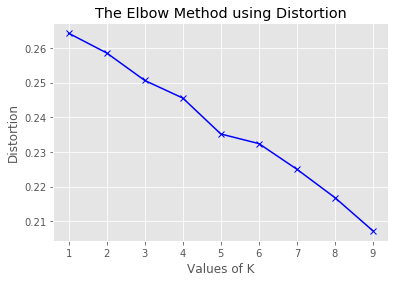

In [235]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

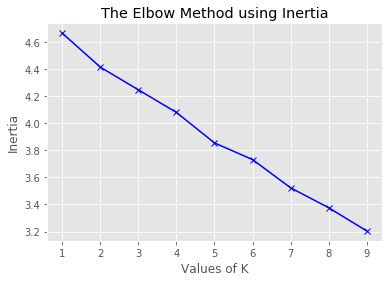

In [236]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Following the elbow method using inertia, we'll set k=4. 

In [237]:
# set number of clusters
kclusters = 4

venues_grouped_clustering = venues_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans_v = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_v.labels_[0:10] 

array([1, 3, 3, 1, 3, 3, 1, 1, 1, 3])

In [238]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Venue Cluster Labels', kmeans_v.labels_)
neighborhoods_venues_sorted.head()
#merge the data frames
nolav_merged = hoodts.set_index('Neighborhood')
nolav_merged = neighborhoods_venues_sorted.join(nolav_merged, on='Neighborhoods')
nolav_merged.tail()

Venue Cluster Labels     Neighborhoods 1st Most Common Venue  \
54                     2   U.S. NAVAL BASE         Boat or Ferry   
55                     1            UPTOWN                   Bar   
56                     1          WEST END                   Bar   
57                     3  WEST LAKE FOREST           Gas Station   
58                     1    WEST RIVERSIDE        Cosmetics Shop   

   2nd Most Common Venue 3rd Most Common Venue      4th Most Common Venue  \
54                 Hotel  Gym / Fitness Center               Credit Union   
55                   Gym     French Restaurant                Music Venue   
56    Seafood Restaurant         Smoothie Shop  Cajun / Creole Restaurant   
57                Lounge     Convenience Store             Sandwich Place   
58           Coffee Shop                   Spa                       Park   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
54           Flower Shop                  Food     Food & Drink Shop   
55                 Hotel        Ice Cream Shop    Israeli Restaurant   
56            Playground           Flea Market           Flower Shop   
57              Pharmacy            Food Truck                 Motel   
58  Gym / Fitness Center         Grocery Store                   Bar   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
54            Food Court            Food Truck            Yoga Studio   
55    Light Rail Station         Movie Theater            Yoga Studio   
56                  Food     Food & Drink Shop             Food Court   
57                   Gym        Discount Store    American Restaurant   
58        Sandwich Place                  Pier               Pie Shop   

    Longitude   Latitude  Incident Count  
54 -90.026093  29.946085             645  
55 -90.107889  29.926449            1303  
56 -90.118618  30.013666             797  
57 -89.992104  30.027043            2795  
58 -90.116730  29.916183            1193

In [239]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
mapv_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nolav_merged['Latitude'], nolav_merged['Longitude'], nolav_merged['Neighborhoods'], nolav_merged['Venue Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mapv_clusters)
       
mapv_clusters

In [278]:
nolav_merged['Venue Cluster Labels'].value_counts().to_frame()

Venue Cluster Labels
1                    36
3                    19
0                     3
2                     1

Now we'll repeat the process for incidents with the `civildf` dataframe. 

In [240]:
civil_onehot = pd.get_dummies(civildf[['Type']], prefix="", prefix_sep="")
civil_onehot['Neighborhoods'] = civildf['Neighborhood'] 
fixed_columns = [civil_onehot.columns[-1]] + list(civil_onehot.columns[:-1])
civil_onehot = civil_onehot[fixed_columns]
civil_onehot.head()

Neighborhoods  AGGRAVATED ARSON  AGGRAVATED ASSAULT  \
0          LEONIDAS                 0                   0   
1  LOWER NINTH WARD                 0                   0   
2   VILLAGE DE LEST                 0                   0   
3             TOURO                 0                   0   
4          ST. ROCH                 0                   0   

   AGGRAVATED ASSAULT DOMESTIC  AGGRAVATED BATTERY  \
0                            0                   0   
1                            0                   0   
2                            0                   0   
3                            0                   0   
4                            0                   0   

   AGGRAVATED BATTERY BY CUTTING  AGGRAVATED BATTERY BY KNIFE  \
0                              0                            0   
1                              0                            0   
2                              0                            0   
3                              0                            0   
4                              0                            0   

   AGGRAVATED BATTERY BY SHOOTING  AGGRAVATED BATTERY DOMESTIC  \
0                               0                            0   
1                               0                            0   
2                               0                            0   
3                               0                            0   
4                               0                            0   

   AGGRAVATED BURGLARY  ...  THEFT FROM EXTERIOR  \
0                    0  ...                    0   
1                    0  ...                    0   
2                    0  ...                    0   
3                    0  ...                    0   
4                    0  ...                    0   

   THEFT FROM EXTERIOR OF VEHICLE  TRUANT VIOLATION  UNATTENDED PACKAGE  \
0                               0                 0                   0   
1                               0                 0                   0   
2                               0                 0                   0   
3                               0                 0                   0   
4                               0                 0                   0   

   UNAUTHORIZED USE OF VEHICLE  UNCLASSIFIED DEATH  \
0                            0                   0   
1                            0                   0   
2                            0                   0   
3                            0                   0   
4                            0                   0   

   UNDERAGE DRINKING VIOLATION  VEHICLE PURSUIT  VIDEO VOYEURISM  \
0                            0                0                0   
1                            0                0                0   
2                            0                0                0   
3                            0                0                0   
4                            0                0                0   

   VIOLATION OF PROTECTION ORDER  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0  

[5 rows x 117 columns]

In [241]:
civil_onehot.shape

(146294, 117)

In [242]:
#group by neighborhood and get incident type frequency
hoods_grouped = civil_onehot.groupby('Neighborhoods').mean().reset_index()
hoods_grouped.head()

Neighborhoods  AGGRAVATED ARSON  AGGRAVATED ASSAULT  \
0   ALGIERS POINT               0.0            0.002326   
1         AUDUBON               0.0            0.000833   
2    B. W. COOPER               0.0            0.013393   
3  BAYOU ST. JOHN               0.0            0.000000   
4         BEHRMAN               0.0            0.010804   

   AGGRAVATED ASSAULT DOMESTIC  AGGRAVATED BATTERY  \
0                     0.000000            0.000000   
1                     0.000000            0.000416   
2                     0.000000            0.002976   
3                     0.002146            0.002146   
4                     0.004449            0.000636   

   AGGRAVATED BATTERY BY CUTTING  AGGRAVATED BATTERY BY KNIFE  \
0                       0.000000                     0.000000   
1                       0.000000                     0.000000   
2                       0.002976                     0.001488   
3                       0.001073                     0.002146   
4                       0.000636                     0.002860   

   AGGRAVATED BATTERY BY SHOOTING  AGGRAVATED BATTERY DOMESTIC  \
0                        0.000000                     0.000000   
1                        0.000000                     0.000416   
2                        0.002976                     0.000000   
3                        0.001073                     0.002146   
4                        0.004131                     0.000636   

   AGGRAVATED BURGLARY  ...  THEFT FROM EXTERIOR  \
0                  0.0  ...             0.002326   
1                  0.0  ...             0.002499   
2                  0.0  ...             0.001488   
3                  0.0  ...             0.005365   
4                  0.0  ...             0.000953   

   THEFT FROM EXTERIOR OF VEHICLE  TRUANT VIOLATION  UNATTENDED PACKAGE  \
0                        0.002326          0.000000                 0.0   
1                        0.002499          0.000833                 0.0   
2                        0.000000          0.000000                 0.0   
3                        0.001073          0.000000                 0.0   
4                        0.000953          0.001271                 0.0   

   UNAUTHORIZED USE OF VEHICLE  UNCLASSIFIED DEATH  \
0                     0.004651            0.002326   
1                     0.001666            0.000000   
2                     0.007440            0.000000   
3                     0.004292            0.000000   
4                     0.006037            0.000953   

   UNDERAGE DRINKING VIOLATION  VEHICLE PURSUIT  VIDEO VOYEURISM  \
0                     0.000000              0.0         0.000000   
1                     0.000833              0.0         0.000000   
2                     0.000000              0.0         0.001488   
3                     0.000000              0.0         0.000000   
4                     0.000000              0.0         0.000636   

   VIOLATION OF PROTECTION ORDER  
0                       0.000000  
1                       0.001666  
2                       0.001488  
3                       0.002146  
4                       0.002860  

[5 rows x 117 columns]

In [243]:
def return_most_common_incident(row, num_top_incident):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_incident]

num_top_incident = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_incident):
    try:
        columns.append('{}{} Most Common Incident'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Incident'.format(ind+1))

# create a new dataframe
neighborhoods_incidents_sorted = pd.DataFrame(columns=columns)
neighborhoods_incidents_sorted['Neighborhoods'] = hoods_grouped['Neighborhoods']

for ind in np.arange(hoods_grouped.shape[0]):
    neighborhoods_incidents_sorted.iloc[ind, 1:] = return_most_common_incident(hoods_grouped.iloc[ind, :], num_top_incident)

neighborhoods_incidents_sorted.head()

Neighborhoods 1st Most Common Incident 2nd Most Common Incident  \
0   ALGIERS POINT    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
1         AUDUBON    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
2    B. W. COOPER                HIT & RUN    BURGLAR ALARM, SILENT   
3  BAYOU ST. JOHN    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
4         BEHRMAN     DOMESTIC DISTURBANCE        SUSPICIOUS PERSON   

  3rd Most Common Incident 4th Most Common Incident 5th Most Common Incident  \
0  SIMPLE BURGLARY VEHICLE     DOMESTIC DISTURBANCE                    THEFT   
1                HIT & RUN          NOISE COMPLAINT  SIMPLE BURGLARY VEHICLE   
2        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE          DRUG VIOLATIONS   
3     DOMESTIC DISTURBANCE  SIMPLE BURGLARY VEHICLE                HIT & RUN   
4    BURGLAR ALARM, SILENT              SHOPLIFTING      DISCHARGING FIREARM   

  6th Most Common Incident 7th Most Common Incident 8th Most Common Incident  \
0    QUALITY OF LIFE ISSUE          NOISE COMPLAINT      DISCHARGING FIREARM   
1            HOLD UP ALARM                    THEFT          DRUG VIOLATIONS   
2         RECKLESS DRIVING  SIMPLE BURGLARY VEHICLE      FUGITIVE ATTACHMENT   
3            HOLD UP ALARM                    THEFT               AUTO THEFT   
4  SIMPLE BATTERY DOMESTIC      FUGITIVE ATTACHMENT                HIT & RUN   

  9th Most Common Incident 10th Most Common Incident  
0                HIT & RUN    SIMPLE CRIMINAL DAMAGE  
1               AUTO THEFT    SIMPLE CRIMINAL DAMAGE  
2               AUTO THEFT   SIMPLE BATTERY DOMESTIC  
3   SIMPLE CRIMINAL DAMAGE        RESIDENCE BURGLARY  
4           SIMPLE BATTERY           DRUG VIOLATIONS

In [244]:
X = hoods_grouped.drop('Neighborhoods', 1)
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1, 10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

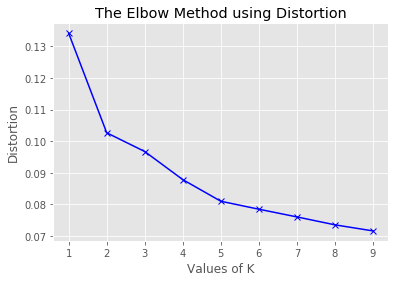

In [245]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

In [246]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [247]:
# set number of clusters
kclusters = 5

nolacrime_clustering = hoods_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nolacrime_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 3, 1, 0, 2, 3, 3, 3, 3])

In [248]:
#merge the frames
merger = hoodts.set_index('Neighborhood')
neighborhoods_incidents_sorted.insert(0, 'Incident Cluster Labels', kmeans.labels_)
merger = neighborhoods_incidents_sorted.join(merger, on='Neighborhoods')
merger.head()

Incident Cluster Labels   Neighborhoods 1st Most Common Incident  \
0                        1   ALGIERS POINT    BURGLAR ALARM, SILENT   
1                        2         AUDUBON    BURGLAR ALARM, SILENT   
2                        3    B. W. COOPER                HIT & RUN   
3                        1  BAYOU ST. JOHN    BURGLAR ALARM, SILENT   
4                        0         BEHRMAN     DOMESTIC DISTURBANCE   

  2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
0        SUSPICIOUS PERSON  SIMPLE BURGLARY VEHICLE     DOMESTIC DISTURBANCE   
1        SUSPICIOUS PERSON                HIT & RUN          NOISE COMPLAINT   
2    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE   
3        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE  SIMPLE BURGLARY VEHICLE   
4        SUSPICIOUS PERSON    BURGLAR ALARM, SILENT              SHOPLIFTING   

  5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
0                    THEFT    QUALITY OF LIFE ISSUE          NOISE COMPLAINT   
1  SIMPLE BURGLARY VEHICLE            HOLD UP ALARM                    THEFT   
2          DRUG VIOLATIONS         RECKLESS DRIVING  SIMPLE BURGLARY VEHICLE   
3                HIT & RUN            HOLD UP ALARM                    THEFT   
4      DISCHARGING FIREARM  SIMPLE BATTERY DOMESTIC      FUGITIVE ATTACHMENT   

  8th Most Common Incident 9th Most Common Incident 10th Most Common Incident  \
0      DISCHARGING FIREARM                HIT & RUN    SIMPLE CRIMINAL DAMAGE   
1          DRUG VIOLATIONS               AUTO THEFT    SIMPLE CRIMINAL DAMAGE   
2      FUGITIVE ATTACHMENT               AUTO THEFT   SIMPLE BATTERY DOMESTIC   
3               AUTO THEFT   SIMPLE CRIMINAL DAMAGE        RESIDENCE BURGLARY   
4                HIT & RUN           SIMPLE BATTERY           DRUG VIOLATIONS   

   Longitude   Latitude  Incident Count  
0 -90.051606  29.952462             430  
1 -90.121450  29.932994            2401  
2 -90.091753  29.951774             672  
3 -90.086517  29.976071             932  
4 -90.026436  29.934817            3147

In [249]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merger['Latitude'], merger['Longitude'], merger['Neighborhoods'], merger['Incident Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [264]:
merger['Incident Cluster Labels'].value_counts().to_frame()

Incident Cluster Labels
0                       20
3                       19
1                       18
2                       14
4                        1

Finally, we merge venue and incident type frequencies into one table to run a combined k-means clustering. 

In [269]:
#data prep for k-means combined
#remove neighborhoods without or with low venue data from hoods_grouped and join with venues_grouped
incidents_venues_grouped = hoods_grouped[hoods_grouped['Neighborhoods'].isin(venues_grouped['Neighborhoods'])].join(venues_grouped.set_index('Neighborhoods'), on='Neighborhoods')
incidents_venues_grouped.head()

Neighborhoods  AGGRAVATED ARSON  AGGRAVATED ASSAULT  \
0   ALGIERS POINT               0.0            0.002326   
1         AUDUBON               0.0            0.000833   
2    B. W. COOPER               0.0            0.013393   
3  BAYOU ST. JOHN               0.0            0.000000   
4         BEHRMAN               0.0            0.010804   

   AGGRAVATED ASSAULT DOMESTIC  AGGRAVATED BATTERY  \
0                     0.000000            0.000000   
1                     0.000000            0.000416   
2                     0.000000            0.002976   
3                     0.002146            0.002146   
4                     0.004449            0.000636   

   AGGRAVATED BATTERY BY CUTTING  AGGRAVATED BATTERY BY KNIFE  \
0                       0.000000                     0.000000   
1                       0.000000                     0.000000   
2                       0.002976                     0.001488   
3                       0.001073                     0.002146   
4                       0.000636                     0.002860   

   AGGRAVATED BATTERY BY SHOOTING  AGGRAVATED BATTERY DOMESTIC  \
0                        0.000000                     0.000000   
1                        0.000000                     0.000416   
2                        0.002976                     0.000000   
3                        0.001073                     0.002146   
4                        0.004131                     0.000636   

   AGGRAVATED BURGLARY  ...  Video Store  Vietnamese Restaurant  \
0                  0.0  ...          0.0                    0.0   
1                  0.0  ...          0.0                    0.0   
2                  0.0  ...          0.0                    0.0   
3                  0.0  ...          0.0                    0.0   
4                  0.0  ...          0.0                    0.0   

   Warehouse Store  Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  \
0              0.0         0.0  0.000000   0.000000     0.0     0.037037   
1              0.0         0.0  0.000000   0.000000     0.0     0.000000   
2              0.0         0.0  0.000000   0.050000     0.0     0.050000   
3              0.0         0.0  0.043478   0.021739     0.0     0.000000   
4              0.0         0.0  0.000000   0.000000     0.0     0.000000   

   Women's Store  Yoga Studio  
0            0.0          0.0  
1            0.0          0.0  
2            0.0          0.0  
3            0.0          0.0  
4            0.0          0.0  

[5 rows x 364 columns]

In [251]:
X = incidents_venues_grouped.drop('Neighborhoods', 1)
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1, 20) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

In [252]:
plt.plot(K, distortions, 'bx-')
plt.xticks(np.linspace(1, 20, 20))
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

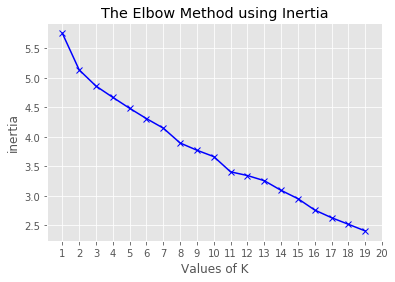

In [253]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('inertia') 
plt.xticks(np.linspace(1, 20, 20))
plt.title('The Elbow Method using Inertia') 
plt.show()

K for values 8 and 11 look viable. We will choose k=8. 

In [254]:
#values of 8 and 11 for k look good. 
# set number of clusters
kclusters = 8

together_clustering = incidents_venues_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(together_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 7, 1, 7, 1, 7, 3, 3, 7])

In [270]:
#merge dataframes to get most common incidents, venues, and previous cluster labels 
together_merged = merger[merger['Neighborhoods'].isin(nolav_merged['Neighborhoods'])].join(nolav_merged.drop(columns=['Longitude', 'Latitude', 'Incident Count']).set_index('Neighborhoods'), on='Neighborhoods')
together_merged.head()

Incident Cluster Labels   Neighborhoods 1st Most Common Incident  \
0                        1   ALGIERS POINT    BURGLAR ALARM, SILENT   
1                        2         AUDUBON    BURGLAR ALARM, SILENT   
2                        3    B. W. COOPER                HIT & RUN   
3                        1  BAYOU ST. JOHN    BURGLAR ALARM, SILENT   
4                        0         BEHRMAN     DOMESTIC DISTURBANCE   

  2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
0        SUSPICIOUS PERSON  SIMPLE BURGLARY VEHICLE     DOMESTIC DISTURBANCE   
1        SUSPICIOUS PERSON                HIT & RUN          NOISE COMPLAINT   
2    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE   
3        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE  SIMPLE BURGLARY VEHICLE   
4        SUSPICIOUS PERSON    BURGLAR ALARM, SILENT              SHOPLIFTING   

  5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
0                    THEFT    QUALITY OF LIFE ISSUE          NOISE COMPLAINT   
1  SIMPLE BURGLARY VEHICLE            HOLD UP ALARM                    THEFT   
2          DRUG VIOLATIONS         RECKLESS DRIVING  SIMPLE BURGLARY VEHICLE   
3                HIT & RUN            HOLD UP ALARM                    THEFT   
4      DISCHARGING FIREARM  SIMPLE BATTERY DOMESTIC      FUGITIVE ATTACHMENT   

  8th Most Common Incident  ...  1st Most Common Venue 2nd Most Common Venue  \
0      DISCHARGING FIREARM  ...          Boat or Ferry                   Bar   
1          DRUG VIOLATIONS  ...  College Arts Building                 Plaza   
2      FUGITIVE ATTACHMENT  ...         Discount Store            Restaurant   
3               AUTO THEFT  ...         Sandwich Place              Wine Bar   
4                HIT & RUN  ...                Stadium            Art Museum   

    3rd Most Common Venue   4th Most Common Venue  5th Most Common Venue  \
0             Coffee Shop                    Park           Neighborhood   
1             Coffee Shop   Outdoors & Recreation         Sandwich Place   
2                  Office  Furniture / Home Store             Food Truck   
3                    Park           Grocery Store            Coffee Shop   
4  Furniture / Home Store           Shopping Mall       Basketball Court   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Pizza Place    Seafood Restaurant     Food & Drink Shop   
1                  Hotel        Shipping Store         Smoothie Shop   
2          Shopping Mall               Brewery        Breakfast Spot   
3     Seafood Restaurant                Bakery           Social Club   
4         Discount Store     Electronics Store                Garden   

  9th Most Common Venue 10th Most Common Venue  
0       Bed & Breakfast           Cupcake Shop  
1         Fishing Store            Flea Market  
2                 Motel   Fast Food Restaurant  
3           Gas Station         Breakfast Spot  
4               Dog Run     Frozen Yogurt Shop  

[5 rows x 26 columns]

In [271]:
#add cluster labels
incidents_venues_grouped.insert(0, 'Combined Cluster Labels', kmeans.labels_)
incidents_venues_grouped.head()

Combined Cluster Labels   Neighborhoods  AGGRAVATED ARSON  \
0                        3   ALGIERS POINT               0.0   
1                        1         AUDUBON               0.0   
2                        7    B. W. COOPER               0.0   
3                        1  BAYOU ST. JOHN               0.0   
4                        7         BEHRMAN               0.0   

   AGGRAVATED ASSAULT  AGGRAVATED ASSAULT DOMESTIC  AGGRAVATED BATTERY  \
0            0.002326                     0.000000            0.000000   
1            0.000833                     0.000000            0.000416   
2            0.013393                     0.000000            0.002976   
3            0.000000                     0.002146            0.002146   
4            0.010804                     0.004449            0.000636   

   AGGRAVATED BATTERY BY CUTTING  AGGRAVATED BATTERY BY KNIFE  \
0                       0.000000                     0.000000   
1                       0.000000                     0.000000   
2                       0.002976                     0.001488   
3                       0.001073                     0.002146   
4                       0.000636                     0.002860   

   AGGRAVATED BATTERY BY SHOOTING  AGGRAVATED BATTERY DOMESTIC  ...  \
0                        0.000000                     0.000000  ...   
1                        0.000000                     0.000416  ...   
2                        0.002976                     0.000000  ...   
3                        0.001073                     0.002146  ...   
4                        0.004131                     0.000636  ...   

   Video Store  Vietnamese Restaurant  Warehouse Store  Whisky Bar  Wine Bar  \
0          0.0                    0.0              0.0         0.0  0.000000   
1          0.0                    0.0              0.0         0.0  0.000000   
2          0.0                    0.0              0.0         0.0  0.000000   
3          0.0                    0.0              0.0         0.0  0.043478   
4          0.0                    0.0              0.0         0.0  0.000000   

   Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  
0   0.000000     0.0     0.037037            0.0          0.0  
1   0.000000     0.0     0.000000            0.0          0.0  
2   0.050000     0.0     0.050000            0.0          0.0  
3   0.021739     0.0     0.000000            0.0          0.0  
4   0.000000     0.0     0.000000            0.0          0.0  

[5 rows x 365 columns]

In [272]:
#merge frames
together_merged = together_merged.join(incidents_venues_grouped.iloc[:, 0:2].set_index('Neighborhoods'), on='Neighborhoods')

In [273]:
together_merged.head()

Incident Cluster Labels   Neighborhoods 1st Most Common Incident  \
0                        1   ALGIERS POINT    BURGLAR ALARM, SILENT   
1                        2         AUDUBON    BURGLAR ALARM, SILENT   
2                        3    B. W. COOPER                HIT & RUN   
3                        1  BAYOU ST. JOHN    BURGLAR ALARM, SILENT   
4                        0         BEHRMAN     DOMESTIC DISTURBANCE   

  2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
0        SUSPICIOUS PERSON  SIMPLE BURGLARY VEHICLE     DOMESTIC DISTURBANCE   
1        SUSPICIOUS PERSON                HIT & RUN          NOISE COMPLAINT   
2    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE   
3        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE  SIMPLE BURGLARY VEHICLE   
4        SUSPICIOUS PERSON    BURGLAR ALARM, SILENT              SHOPLIFTING   

  5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
0                    THEFT    QUALITY OF LIFE ISSUE          NOISE COMPLAINT   
1  SIMPLE BURGLARY VEHICLE            HOLD UP ALARM                    THEFT   
2          DRUG VIOLATIONS         RECKLESS DRIVING  SIMPLE BURGLARY VEHICLE   
3                HIT & RUN            HOLD UP ALARM                    THEFT   
4      DISCHARGING FIREARM  SIMPLE BATTERY DOMESTIC      FUGITIVE ATTACHMENT   

  8th Most Common Incident  ... 2nd Most Common Venue   3rd Most Common Venue  \
0      DISCHARGING FIREARM  ...                   Bar             Coffee Shop   
1          DRUG VIOLATIONS  ...                 Plaza             Coffee Shop   
2      FUGITIVE ATTACHMENT  ...            Restaurant                  Office   
3               AUTO THEFT  ...              Wine Bar                    Park   
4                HIT & RUN  ...            Art Museum  Furniture / Home Store   

    4th Most Common Venue  5th Most Common Venue  6th Most Common Venue  \
0                    Park           Neighborhood            Pizza Place   
1   Outdoors & Recreation         Sandwich Place                  Hotel   
2  Furniture / Home Store             Food Truck          Shopping Mall   
3           Grocery Store            Coffee Shop     Seafood Restaurant   
4           Shopping Mall       Basketball Court         Discount Store   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0     Seafood Restaurant     Food & Drink Shop       Bed & Breakfast   
1         Shipping Store         Smoothie Shop         Fishing Store   
2                Brewery        Breakfast Spot                 Motel   
3                 Bakery           Social Club           Gas Station   
4      Electronics Store                Garden               Dog Run   

  10th Most Common Venue Combined Cluster Labels  
0           Cupcake Shop                       3  
1            Flea Market                       1  
2   Fast Food Restaurant                       7  
3         Breakfast Spot                       1  
4     Frozen Yogurt Shop                       7  

[5 rows x 27 columns]

In [259]:
# create map
map_combined_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(together_merged['Latitude'], together_merged['Longitude'], together_merged['Neighborhoods'], together_merged['Combined Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_combined_clusters)
       
map_combined_clusters

In [274]:
together_merged['Combined Cluster Labels'].value_counts().to_frame()

Combined Cluster Labels
3                       25
1                       15
7                       13
2                        2
6                        1
5                        1
4                        1
0                        1

<a name="combined-choropleth"></a>

Below we'll combine our final cluster labels with the choropleth map in section 3.1.5.

In [289]:
#combine with choropleth
# create map
map_combined_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# generate choropleth map using the neighborhood-safety related incidents in nola by neighborhood
map_combined_clusters.choropleth(
    geo_data=nola_geo,
    data=hoodts,
    columns=['Neighborhood', 'Incident Count'],
    key_on='feature.properties.gnocdc_lab',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhood Safety Related Incidents 2018',
    reset=True
)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(together_merged['Latitude'], together_merged['Longitude'], together_merged['Neighborhoods'], together_merged['Combined Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_combined_clusters)
       
map_combined_clusters

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [ ]:
#nolav_merged - venues
#merger - incidents
#together_merged - together

<a name="Results"></a>

## 4. Results
---
We've now processed a great deal of data. Our main incidents frame, `civildf`, consisted of over 146000 incidents from 2018. Foursquare returned 1675 different venues for New Orleans. First looking at the results from the analysis on incidents:

[3.1.1a](#3.1.1) shows the top 3 incidents (Burglar alarm (silent), suspicious person, and domestic disturbance) greatly outweighing all others. It is not surprising that an automated call would be the top type, however the occurrence rate of suspicious person calls indicates a general distrust of others within the city. Looking at `Top 20 Neighborhoods Suspicious Person` in [3.1.1b](#3.1.1b), we can see that suspicious person calls are most problematic in Central City and Little Woods. Theft occurs most in the Central Business District and the French Quarter, perhaps because of businesses or tourists in the area.
 
In [3.1.2](#3.1.2) we notice that nearly 100 out of 116 incident types occurred less than 2335 times. Our interquartile range is even smaller at 743, the second quartile starting at 28 incidents and the 3rd ending at 771 incidents total.This indicates that most incidents do not occur or are not reported nearly as often as a select few. Furthermore, city resources may be being spent at a disproportionate rate. 

[3.1.3](#3.1.3) and [3.1.4](#3.1.4) show that we have four neighborhoods with much higher incident occurrence than average (over 2 standard deviations above the mean). Referring to our table `hoodtotals`, these are Little Woods, Central City, Central Business District, and the French Quarter. These may require special attention from city officials.     

The choropleth map produced in [3.1.5](#3.1.5) clearly shows a group of problem areas near Central City and downtown New Orleans, along with the extreme red zone, Little Woods, in New Orleans East near Lake Pontchartrain. Looking at this map could be useful for those sightseeing around the city and trying to avoid problem areas. 

With [3.1.6a](#3.1.6), *Total Incident Count by Month*, we see large variations of over 1.25 std from the mean in January, May, July, and November. Our peaks are at July and May while the lowest periods for incidents are January and November. July is the all-time high month for incidents at 13004 total (over 1.5 std above the mean). November is the minimum with only 11464 incidents. The next plot, *Timeseries of Incidents for Quartile Median Neighborhoods*,  shows neighborhood incident trends over the year. These remain fairly constant without significant variation.  	

Foursquare retrieved **1683 venues** with **252 different types** for 70 neighborhoods in New Orleans. Most venue types had a low count (mean of 6.7) while a few had very high counts. These top venue types are bars, hotels, and coffee shops with cajun/ creole restaurants following in fourth. For more, see [3.1.7](#3.1.7).

Moving on to [k-means](#k-means)--clustering did not perform very well when working with foursquare venue data. Many neighborhoods were underrepresented and some venue types were over represented. The inertia and distortion values were subsequently much larger for clustering with venues than with incidents or combined. K-means produced 4 clusters for Neighborhoods based on venue type frequency, 5 clusters based on incident type frequency, and 8 clusters on combined incident and venue type frequencies. Labelling of these clusters will follow in the discussion section.  

<a name="Discussion"></a>
## 5. Discussion
---
Overall, much was uncovered through data analysis of incidents, leading to possible insights for stakeholders in policy, policing, and non-profit. The ability to harness data of scale to precision will surely become more essential in decision making through all sectors. The following discussion provides points from the exploratory analysis and k-means clustering that can help towards the goal of mindfully allocating city resources.

Two major problems noted in the exploratory analysis are suspicious persons and theft. The high occurrence of suspicious person reports seen in Central City and Little Woods (refer to [3.1.1](#3.1.1)) may indicate low levels of social trust in the area. Organizing community events in order to familiarize members with one another may help mitigate the occurrence of suspicious person reports, freeing up police time and resources. Establishment or encouragement of local neighborhood watches may also be beneficial for these areas. 

Theft is by far the biggest problem in the Central Business District and the French Quarter. Already, there are frequent police patrols in these areas. Though controversial, increasing surveillance cameras may act as a deterrent, with results able to be measured in years to come. Other solutions could be explored by seeing what cities in different regions have done to address theft occurrence.

The time series analysis conducted in [3.1.6](#3.1.6) provides a snap-shot of how crime changes over the year. This data becomes more powerful if we combine it with multiple years worth of data. We could see trends of total incidents per month and suggest allocation of resources based on month helping those making staffing decisions for police personnel. Furthermore, we could see how different incident types and neighborhoods change based on month. Regression could even be used to predict the amount of incidents by type or neighborhood based on time of day or month. This may be a topic of interest to city officials for further research

Unfortunately the Foursquare Venue data for New Orleans is rather lacking. It does not paint a clear picture of venues in some neighborhoods, and over represents others. This leads to a bias when clustering neighborhoods and also throws off insights when linking venues with crime type. With these caveats and warnings, we'll examine the combined clusterings of venue types and incident types with the choropleth map [here](#combined-choropleth) and their data below.

**Cluster 1**

In [287]:
together_merged[together_merged['Combined Cluster Labels']==0].drop(columns=['Incident Cluster Labels', 'Venue Cluster Labels', 'Combined Cluster Labels'])

Neighborhoods 1st Most Common Incident 2nd Most Common Incident  \
18   FISCHER DEV     DOMESTIC DISTURBANCE                HIT & RUN   

   3rd Most Common Incident 4th Most Common Incident 5th Most Common Incident  \
18        SUSPICIOUS PERSON  SIMPLE BATTERY DOMESTIC    BURGLAR ALARM, SILENT   

   6th Most Common Incident       7th Most Common Incident  \
18      FUGITIVE ATTACHMENT  DRIVING WHILE UNDER INFLUENCE   

   8th Most Common Incident 9th Most Common Incident  ...  \
18                    FIGHT   SIMPLE CRIMINAL DAMAGE  ...   

   1st Most Common Venue  2nd Most Common Venue  3rd Most Common Venue  \
18        Sandwich Place          Women's Store      Electronics Store   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
18            Flea Market          Home Service                 Hotel   

     7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
18  Furniture / Home Store     French Restaurant      Football Stadium   

   10th Most Common Venue  
18             Food Truck  

[1 rows x 24 columns]

Cluster 1 consists of a single neighborhood, Fischer Dev. It has a relatively low amount of incidents, but they consist of a slightly more serious kind, such as domestic battery and fight. These moderate-type incidents are paired with sub-urban venues. We'll call this cluster **moderate-suburban**. 

**Cluster 2**

In [290]:
together_merged[together_merged['Combined Cluster Labels']==1].drop(columns=['Incident Cluster Labels', 'Venue Cluster Labels', 'Combined Cluster Labels'])

Neighborhoods 1st Most Common Incident 2nd Most Common Incident  \
1               AUDUBON    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
3        BAYOU ST. JOHN    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
5           BLACK PEARL    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
14      EAST CARROLLTON    BURGLAR ALARM, SILENT          NOISE COMPLAINT   
15       EAST RIVERSIDE    BURGLAR ALARM, SILENT  SIMPLE BURGLARY VEHICLE   
17              FILMORE    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
23      GARDEN DISTRICT    BURGLAR ALARM, SILENT                HIT & RUN   
30        IRISH CHANNEL    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
32  LAKE TERRACE & OAKS    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
34             LAKEVIEW    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
35             LAKEWOOD    BURGLAR ALARM, SILENT         RECKLESS DRIVING   
61                TOURO    BURGLAR ALARM, SILENT                HIT & RUN   
65               UPTOWN    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
68             WEST END    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
70       WEST RIVERSIDE    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   

   3rd Most Common Incident 4th Most Common Incident 5th Most Common Incident  \
1                 HIT & RUN          NOISE COMPLAINT  SIMPLE BURGLARY VEHICLE   
3      DOMESTIC DISTURBANCE  SIMPLE BURGLARY VEHICLE                HIT & RUN   
5   SIMPLE BURGLARY VEHICLE     DOMESTIC DISTURBANCE                HIT & RUN   
14        SUSPICIOUS PERSON                HIT & RUN  SIMPLE BURGLARY VEHICLE   
15     DOMESTIC DISTURBANCE        SUSPICIOUS PERSON                HIT & RUN   
17     DOMESTIC DISTURBANCE  SIMPLE BURGLARY VEHICLE            HOLD UP ALARM   
23               AUTO THEFT  SIMPLE BURGLARY VEHICLE        SUSPICIOUS PERSON   
30                HIT & RUN  SIMPLE BURGLARY VEHICLE                    THEFT   
32  SIMPLE BURGLARY VEHICLE          DRUG VIOLATIONS            HOLD UP ALARM   
34  SIMPLE BURGLARY VEHICLE                HIT & RUN            HOLD UP ALARM   
35                HIT & RUN        SUSPICIOUS PERSON  HIT & RUN WITH INJURIES   
61        SUSPICIOUS PERSON                    THEFT  SIMPLE BURGLARY VEHICLE   
65  SIMPLE BURGLARY VEHICLE                HIT & RUN   SIMPLE CRIMINAL DAMAGE   
68            HOLD UP ALARM     DOMESTIC DISTURBANCE  SIMPLE BURGLARY VEHICLE   
70              SHOPLIFTING  SIMPLE BURGLARY VEHICLE                HIT & RUN   

   6th Most Common Incident                7th Most Common Incident  \
1             HOLD UP ALARM                                   THEFT   
3             HOLD UP ALARM                                   THEFT   
5           NOISE COMPLAINT                           HOLD UP ALARM   
14     DOMESTIC DISTURBANCE                              AUTO THEFT   
15               AUTO THEFT                                   THEFT   
17              SHOPLIFTING                              AUTO THEFT   
23                    THEFT                           HOLD UP ALARM   
30     DOMESTIC DISTURBANCE                           HOLD UP ALARM   
32              SHOPLIFTING                               HIT & RUN   
34         RECKLESS DRIVING                         NOISE COMPLAINT   
35            HOLD UP ALARM  BURGLAR ALARM, SILENT, FAR NO RESPONSE   
61          NOISE COMPLAINT                          SIMPLE BATTERY   
65            HOLD UP ALARM                                   THEFT   
68                HIT & RUN                         NOISE COMPLAINT   
70     DOMESTIC DISTURBANCE                           HOLD UP ALARM   

   8th Most Common Incident 9th Most Common Incident  ...  \
1           DRUG VIOLATIONS               AUTO THEFT  ...   
3                AUTO THEFT   SIMPLE CRIMINAL DAMAGE  ...   
5                AUTO THEFT                    FIGHT  ...   
14            HOLD UP ALARM   SIMPLE CRIMINAL DAMAGE  ...   
15          NOISE COMPLAINT           

Cluster 2 has 15 neighborhoods. We see low incident rate neighborhoods in cluster 2 in more expensive areas. There are universities, bars, coffee shops, and restaurants with less serious incidents and auto-related incidents. With lots of walkable, long-stay venues, we might connect auto-related incidents and theft with these urban-stay locales. We'll label cluster 2 as **car-beware, urban-stay**. 

**Cluster 3**

In [291]:
together_merged[together_merged['Combined Cluster Labels']==2].drop(columns=['Incident Cluster Labels', 'Venue Cluster Labels', 'Combined Cluster Labels'])

Neighborhoods 1st Most Common Incident 2nd Most Common Incident  \
37   LITTLE WOODS    BURGLAR ALARM, SILENT     DOMESTIC DISTURBANCE   
49  PINES VILLAGE    BURGLAR ALARM, SILENT     DOMESTIC DISTURBANCE   

   3rd Most Common Incident 4th Most Common Incident 5th Most Common Incident  \
37        SUSPICIOUS PERSON  SIMPLE BURGLARY VEHICLE  SIMPLE BATTERY DOMESTIC   
49        SUSPICIOUS PERSON                HIT & RUN  SIMPLE BATTERY DOMESTIC   

   6th Most Common Incident 7th Most Common Incident 8th Most Common Incident  \
37               AUTO THEFT   SIMPLE CRIMINAL DAMAGE                HIT & RUN   
49              SHOPLIFTING                    FIGHT               AUTO THEFT   

   9th Most Common Incident  ... 1st Most Common Venue  2nd Most Common Venue  \
37                    THEFT  ...    Seafood Restaurant         Cosmetics Shop   
49  SIMPLE BURGLARY VEHICLE  ...           Pizza Place          Event Service   

    3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
37            Gas Station                   Food              Pharmacy   
49                   Food              Nightclub    Seafood Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
37  Gym / Fitness Center                Lounge     Convenience Store   
49        Discount Store  Ethiopian Restaurant     Electronics Store   

   9th Most Common Venue  10th Most Common Venue  
37             Nightclub      Falafel Restaurant  
49                Garden  Furniture / Home Store  

[2 rows x 24 columns]

Cluster 3 has 2 neighborhoods in high-incident zones. These are in New Orleans East, with mostly car-accessed venues. This cluster will be labelled **car-accessessed risk**.

**Cluster 4**

In [292]:
together_merged[together_merged['Combined Cluster Labels']==3].drop(columns=['Incident Cluster Labels', 'Venue Cluster Labels', 'Combined Cluster Labels'])

Neighborhoods 1st Most Common Incident  \
0                ALGIERS POINT    BURGLAR ALARM, SILENT   
7                      BYWATER    BURGLAR ALARM, SILENT   
8    CENTRAL BUSINESS DISTRICT                    THEFT   
10                   CITY PARK    BURGLAR ALARM, SILENT   
16                 FAIRGROUNDS    BURGLAR ALARM, SILENT   
21              FRENCH QUARTER    BURGLAR ALARM, SILENT   
22                      FRERET    BURGLAR ALARM, SILENT   
24            GENTILLY TERRACE    BURGLAR ALARM, SILENT   
25              GENTILLY WOODS    BURGLAR ALARM, SILENT   
28                  HOLY CROSS    BURGLAR ALARM, SILENT   
29                   IBERVILLE        SUSPICIOUS PERSON   
36                    LEONIDAS    BURGLAR ALARM, SILENT   
38       LOWER GARDEN DISTRICT    BURGLAR ALARM, SILENT   
40                     MARIGNY    BURGLAR ALARM, SILENT   
41  MARLYVILLE - FONTAINEBLEAU    BURGLAR ALARM, SILENT   
42                    MID-CITY    BURGLAR ALARM, SILENT   
43                       MILAN    BURGLAR ALARM, SILENT   
46                     NAVARRE    BURGLAR ALARM, SILENT   
51          PONTCHARTRAIN PARK    BURGLAR ALARM, SILENT   
52              READ BLVD EAST    BURGLAR ALARM, SILENT   
54                SEVENTH WARD        SUSPICIOUS PERSON   
55                 ST. ANTHONY    BURGLAR ALARM, SILENT   
57                  ST. CLAUDE    BURGLAR ALARM, SILENT   
59              ST. THOMAS DEV    BURGLAR ALARM, SILENT   
62             TREME - LAFITTE        SUSPICIOUS PERSON   

   2nd Most Common Incident 3rd Most Common Incident 4th Most Common Incident  \
0         SUSPICIOUS PERSON  SIMPLE BURGLARY VEHICLE     DOMESTIC DISTURBANCE   
7               SHOPLIFTING        SUSPICIOUS PERSON                HIT & RUN   
8     BURGLAR ALARM, SILENT                HIT & RUN        SUSPICIOUS PERSON   
10        SUSPICIOUS PERSON                HIT & RUN  SIMPLE BURGLARY VEHICLE   
16        SUSPICIOUS PERSON                HIT & RUN     DOMESTIC DISTURBANCE   
21        SUSPICIOUS PERSON                    THEFT          DRUG VIOLATIONS   
22        SUSPICIOUS PERSON                HIT & RUN     DOMESTIC DISTURBANCE   
24        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE                HIT & RUN   
25     DOMESTIC DISTURBANCE        SUSPICIOUS PERSON              SHOPLIFTING   
28     DOMESTIC DISTURBANCE        SUSPICIOUS PERSON      DISCHARGING FIREARM   
29          DRUG VIOLATIONS    BURGLAR ALARM, SILENT     DOMESTIC DISTURBANCE   
36        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE                HIT & RUN   
38                HIT & RUN        SUSPICIOUS PERSON                    THEFT   
40        SUSPICIOUS PERSON          NOISE COMPLAINT                    THEFT   
41        SUSPICIOUS PERSON  SIMPLE BURGLARY VEHICLE              SHOPLIFTING   
42        SUSPICIOUS PERSON                HIT & RUN      FUGITIVE ATTACHMENT   
43        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE                HIT & RUN   
46        SUSPICIOUS PERSON                HIT & RUN  SIMPLE BURGLARY VEHICLE   
51        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE  SIMPLE BURGLARY VEHICLE   
52     DOMESTIC DISTURBANCE        SUSPICIOUS PERSON                HIT & RUN   
54     DOMESTIC DISTURBANCE    BURGLAR ALARM, SILENT                HIT & RUN   
55          NOISE COMPLAINT     DOMESTIC DISTURBANCE        SUSPICIOUS PERSON   
57        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE                HIT & RUN   
59        SUSPICIOUS PERSON     DOMESTIC DISTURBANCE              SHOPLIFTING   
62    BURGLAR ALARM, SILENT     DOMESTIC DISTURBANCE                HIT & RUN   

   5th Most Common Incident 6th Most Common Incident 7th Most Common Incident  \
0                     THEFT    QUALITY OF LIFE ISSUE          NOISE COMPLAINT   
7      DOMESTIC DISTURBANCE               AUTO THEFT                    THEFT   
8            SIMPLE BATTERY                    FIGHT              SHOPLIFTING   
10         RECKLESS DRIVING                    THEF

Cluster 4 is one of the largest clusters with 25 neighborhoods. Venues mostly consist of restaurants and incidents mostly consist of burglar alarms and suspicious persons. We can tenuously infer that an increased presence of restaurants gets more break-in attempts in an area, coinciding with suspicious persons. This cluster will be labelled **restaurant-break-in**. 

**Cluster 5**

In [293]:
together_merged[together_merged['Combined Cluster Labels']==4].drop(columns=['Incident Cluster Labels', 'Venue Cluster Labels', 'Combined Cluster Labels'])

Neighborhoods 1st Most Common Incident 2nd Most Common Incident  \
56  ST. BERNARD AREA    BURGLAR ALARM, SILENT     DOMESTIC DISTURBANCE   

   3rd Most Common Incident 4th Most Common Incident 5th Most Common Incident  \
56        SUSPICIOUS PERSON                HIT & RUN           SIMPLE BATTERY   

   6th Most Common Incident 7th Most Common Incident 8th Most Common Incident  \
56      FUGITIVE ATTACHMENT  SIMPLE BATTERY DOMESTIC         RECKLESS DRIVING   

   9th Most Common Incident  ... 1st Most Common Venue  2nd Most Common Venue  \
56          DRUG VIOLATIONS  ...            Skate Park    Rental Car Location   

    3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
56       Business Service         Massage Studio                 River   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
56        Scenic Lookout                  Food         Fishing Store   

   9th Most Common Venue 10th Most Common Venue  
56           Flea Market            Flower Shop  

[1 rows x 24 columns]

Another single neighborhood in a low-incident zone, **St. Bernard**.

**Cluster 6**

In [294]:
together_merged[together_merged['Combined Cluster Labels']==5].drop(columns=['Incident Cluster Labels', 'Venue Cluster Labels', 'Combined Cluster Labels'])

Neighborhoods 1st Most Common Incident 2nd Most Common Incident  \
39  LOWER NINTH WARD     DOMESTIC DISTURBANCE    BURGLAR ALARM, SILENT   

   3rd Most Common Incident 4th Most Common Incident 5th Most Common Incident  \
39        SUSPICIOUS PERSON                HIT & RUN  SIMPLE BATTERY DOMESTIC   

   6th Most Common Incident 7th Most Common Incident 8th Most Common Incident  \
39   SIMPLE CRIMINAL DAMAGE      DISCHARGING FIREARM          DRUG VIOLATIONS   

   9th Most Common Incident  ... 1st Most Common Venue  2nd Most Common Venue  \
39                    THEFT  ...     Convenience Store          Grocery Store   

    3rd Most Common Venue  4th Most Common Venue      5th Most Common Venue  \
39    American Restaurant           Neighborhood  Cajun / Creole Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
39           Yoga Studio     Food & Drink Shop            Food Court   

   9th Most Common Venue 10th Most Common Venue  
39            Food Truck       Football Stadium  

[1 rows x 24 columns]

Previously a hot-zone pre-Hurricane Katrina, it now has a low-moderate incident rate, **Lower Ninth Ward**.

**Cluster 7**

In [295]:
together_merged[together_merged['Combined Cluster Labels']==6].drop(columns=['Incident Cluster Labels', 'Venue Cluster Labels', 'Combined Cluster Labels'])

Neighborhoods 1st Most Common Incident 2nd Most Common Incident  \
64  U.S. NAVAL BASE     DOMESTIC DISTURBANCE        SUSPICIOUS PERSON   

   3rd Most Common Incident 4th Most Common Incident 5th Most Common Incident  \
64      FUGITIVE ATTACHMENT          DRUG VIOLATIONS  SIMPLE BATTERY DOMESTIC   

   6th Most Common Incident 7th Most Common Incident 8th Most Common Incident  \
64    BURGLAR ALARM, SILENT      DISCHARGING FIREARM               AUTO THEFT   

   9th Most Common Incident  ... 1st Most Common Venue  2nd Most Common Venue  \
64                HIT & RUN  ...         Boat or Ferry                  Hotel   

    3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
64   Gym / Fitness Center           Credit Union           Flower Shop   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
64                  Food     Food & Drink Shop            Food Court   

   9th Most Common Venue 10th Most Common Venue  
64            Food Truck            Yoga Studio  

[1 rows x 24 columns]

Low-incident zone, **U.S. Naval Base**.

**Cluster 8**

In [297]:
together_merged[together_merged['Combined Cluster Labels']==7].drop(columns=['Incident Cluster Labels', 'Venue Cluster Labels', 'Combined Cluster Labels'])

Neighborhoods 1st Most Common Incident 2nd Most Common Incident  \
2              B. W. COOPER                HIT & RUN    BURGLAR ALARM, SILENT   
4                   BEHRMAN     DOMESTIC DISTURBANCE        SUSPICIOUS PERSON   
6                 BROADMOOR    BURGLAR ALARM, SILENT        SUSPICIOUS PERSON   
9              CENTRAL CITY        SUSPICIOUS PERSON    BURGLAR ALARM, SILENT   
12                  DILLARD    BURGLAR ALARM, SILENT     DOMESTIC DISTURBANCE   
13                    DIXON        SUSPICIOUS PERSON                HIT & RUN   
26                GERT TOWN    BURGLAR ALARM, SILENT              SHOPLIFTING   
27               HOLLYGROVE     DOMESTIC DISTURBANCE        SUSPICIOUS PERSON   
45                 McDONOGH     DOMESTIC DISTURBANCE    BURGLAR ALARM, SILENT   
58                 ST. ROCH    BURGLAR ALARM, SILENT     DOMESTIC DISTURBANCE   
60  TALL TIMBERS - BRECHTEL    BURGLAR ALARM, SILENT     DOMESTIC DISTURBANCE   
63         TULANE - GRAVIER                HIT & RUN    BURGLAR ALARM, SILENT   
69         WEST LAKE FOREST    BURGLAR ALARM, SILENT     DOMESTIC DISTURBANCE   

   3rd Most Common Incident 4th Most Common Incident 5th Most Common Incident  \
2         SUSPICIOUS PERSON     DOMESTIC DISTURBANCE          DRUG VIOLATIONS   
4     BURGLAR ALARM, SILENT              SHOPLIFTING      DISCHARGING FIREARM   
6      DOMESTIC DISTURBANCE          DRUG VIOLATIONS  SIMPLE BURGLARY VEHICLE   
9      DOMESTIC DISTURBANCE                HIT & RUN          DRUG VIOLATIONS   
12        SUSPICIOUS PERSON              SHOPLIFTING                HIT & RUN   
13     DOMESTIC DISTURBANCE    BURGLAR ALARM, SILENT   SIMPLE CRIMINAL DAMAGE   
26        SUSPICIOUS PERSON          DRUG VIOLATIONS                HIT & RUN   
27    BURGLAR ALARM, SILENT          DRUG VIOLATIONS      FUGITIVE ATTACHMENT   
45        SUSPICIOUS PERSON  SIMPLE BATTERY DOMESTIC          DRUG VIOLATIONS   
58        SUSPICIOUS PERSON                HIT & RUN  SIMPLE BATTERY DOMESTIC   
60              SHOPLIFTING        SUSPICIOUS PERSON                HIT & RUN   
63        SUSPICIOUS PERSON              SHOPLIFTING     DOMESTIC DISTURBANCE   
69        SUSPICIOUS PERSON  SIMPLE BATTERY DOMESTIC                HIT & RUN   

   6th Most Common Incident 7th Most Common Incident 8th Most Common Incident  \
2          RECKLESS DRIVING  SIMPLE BURGLARY VEHICLE      FUGITIVE ATTACHMENT   
4   SIMPLE BATTERY DOMESTIC      FUGITIVE ATTACHMENT                HIT & RUN   
6                 HIT & RUN              SHOPLIFTING      FUGITIVE ATTACHMENT   
9               SHOPLIFTING      FUGITIVE ATTACHMENT           SIMPLE BATTERY   
12      FUGITIVE ATTACHMENT  SIMPLE BATTERY DOMESTIC  SIMPLE BURGLARY VEHICLE   
13          NOISE COMPLAINT         RECKLESS DRIVING      FUGITIVE ATTACHMENT   
26     DOMESTIC DISTURBANCE      FUGITIVE ATTACHMENT          NOISE COMPLAINT   
27  SIMPLE BATTERY DOMESTIC                HIT & RUN            HOLD UP ALARM   
45                    FIGHT      FUGITIVE ATTACHMENT          NOISE COMPLAINT   
58                    THEFT               AUTO THEFT   SIMPLE CRIMINAL DAMAGE   
60      FUGITIVE ATTACHMENT  SIMPLE BATTERY DOMESTIC  SIMPLE BURGLARY VEHICLE   
63                 HOMELESS    QUALITY OF LIFE ISSUE                    THEFT   
69         RECKLESS DRIVING  SIMPLE BURGLARY VEHICLE               AUTO THEFT   

   9th Most Common Incident  ... 1st Most Common Venue  2nd Most Common Venue  \
2                AUTO THEFT  ...        Discount Store             Restaurant   
4            SIMPLE BATTERY  ...               Stadium             Art Museum   
6                AUTO THEFT  ...              Pharmacy                 Bakery   
9                     THEFT  ...                  Park                    Gym   
12                    THEFT  ...                  Bank         Discount Store   
13          DRUG VIOLATIONS  ...        Discount Store         Breakfast Spot   
26  SIMPLE BURGLARY VEHICLE  ...          

Our last cluster of 13 neighborhoods are in moderate-high incident zones. Incident types are more serious with theft, battery, and drug violations common. Frequent venue types are gas stations, discount stores, light-industrial venues, and sports-related venues. We'll call this cluster **Moderate-light industrial**.

We can draw insights from clusters 2, 4, and 8. With Clustering from 2 and we can reasonably say that the more long-period-stay venues in an area, the more car-break ins you can expect. Group 4 suggests that restaurants are targets for burglary, with high alarm and suspicious person incidents. Lastly, group 8 shows a tenuous relation between moderate-crime and light industrial areas.

<a name="Conclusion"></a>

## 6. Conclusion
---
The purpose of this project was to elucidate data-based insights and relations between incidents and venues in New Orleans. The data analysis on incidents and venues has been able to produce take-aways toward the efficient use of police and public resources showing where, what, and when incidents occur along with venues they may be related with. K-means loosely linked car-related incidents with long-stay venues, burglar alarms and suspicious persons with restaurants, and moderate-crime with light industrial areas. Lastly, the choropleth map is an immediate visual aid in identifying problem areas in the city. Combining this type of data along with that already available in resources such as the [opportunity atlas](https://www.opportunityatlas.org/) can help us better relate diverse factors such as income, education, and housing price to ongoing crime.